# DEL/UFRJ - EEL891 - Semestre 2018-2 - Trabalho 1

**Nome:** Gabriel Gazola Milan  **DRE:** 116034377

**Kaggle profile:** https://www.kaggle.com/gabrielmilan

**GitHub profile:** https://www.github.com/gabriel-milan

## Análise exploratória e manipulação dos dados

Abaixo as bibliotecas que utilizaremos para análise dos dados, sendo:
* *pandas* para geração de um modelo de dados estruturado e manipulação do mesmo;
* *numpy e scipy* para cálculos matemáticos;
* *seaborn* com ferramentas de estatística;
* *matplotlib* para visualização de dados.

In [1]:
# Importando bibliotecas para análise
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import boxcox1p

# Inline plotting
%matplotlib inline

# Box cox transformation lambda
bclambda = 0.00001
max_iter = 15000

# Carregando dados
raw_train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Separando 25% dos dados de treino para validação
validation = raw_train[:int(len(raw_train)*.25)].copy()
train = raw_train[int(len(raw_train)*.25):].copy()

print(train.shape)
print(validation.shape)
print(test.shape)

#print(raw_train[raw_train.Id == 2149], raw_train[raw_train.Id == 2325], raw_train[raw_train.Id == 2989])

(3513, 21)
(1170, 21)
(2000, 20)


### Observação dos dados

Ao início da análise exploratória, verificou-se a descrição do conjunto de treino fornecida pela biblioteca *pandas* e os primeiros dados do conjunto, como exemplo

In [2]:
train.describe()

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
count,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3.513000e+03
mean,4926.000000,3.043268,1.435241,1.707373,125.019926,14.997438,0.315400,0.031028,0.551096,0.154569,0.038429,0.139767,0.007401,0.015087,0.095929,0.028181,8.226956e+05
std,1014.260075,0.877039,1.113123,1.220924,108.460201,307.163525,0.464741,0.173417,0.497453,0.361545,0.192256,0.346794,0.085723,0.121916,0.294536,0.165513,5.857940e+06
min,3170.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000e+02
25%,4048.000000,3.000000,1.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.550000e+05
50%,4926.000000,3.000000,1.000000,2.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000e+05
75%,5804.000000,4.000000,2.000000,2.000000,150.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.200000e+05
max,6682.000000,9.000000,6.000000,30.000000,2045.000000,17450.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.400000e+08


In [3]:
train.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
1170,3170,Apartamento,Caxanga,Imobiliaria,2,1,1,55,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,290000.0
1171,3171,Apartamento,Imbiribeira,Imobiliaria,3,1,1,72,0,nenhum,...,0,0,0,0,0,0,0,0,0,315000.0
1172,3172,Casa,Pina,Imobiliaria,3,1,2,180,210,piscina,...,0,1,0,0,0,0,0,0,0,1150000.0
1173,3173,Casa,Ilha do Leite,Pessoa Fisica,7,2,4,240,252,nenhum,...,0,0,0,0,0,0,0,0,0,1900000.0
1174,3174,Apartamento,Boa Viagem,Imobiliaria,2,1,1,62,28,nenhum,...,0,0,0,0,0,0,0,0,0,350000.0


### Manipulação da coluna "diferenciais"

Foi identificado que a coluna "diferenciais" consiste em uma tupla de dados categóricos não estruturada. A seguir, será feito um *parsing* desses dados, de forma a gerar novas colunas, colocando esses dados de maneira estruturada.

In [4]:
# Construindo um conjunto com todas as palavras exibidas na coluna "diferenciais"
words_set = set()
for data in train['diferenciais']:
    for word in data.split(' '):
        words_set.add(word)
#print ("Raw words set: {}".format(words_set))

#print ("")

# Algumas stop-words serão removidas manualmente
to_be_removed = ['o', 'e', 'de', 'nenhum', 'para']
for remove_word in to_be_removed:
    words_set.remove(remove_word)
#print ("Removed stop-words set: {}".format(words_set))

#print ("")

# Agora verificamos quais palavras restaram, tentando formar categorias de dados
for word in words_set:
    #print ("--- Word: {}".format(word))
    cat_list = []
    for data in train['diferenciais']:
        if word in data:
            cat_list.append(data)
    #print (cat_list)
    
# Ainda que com muito texto, foi possível encontrar categorias, descritas abaixo
add_columns = set([
    'esquina',
    'campo de futebol',
    'children care',
    'frente para o mar',
    'salao de jogos',
    'sauna',
    'quadra poliesportiva',
    'salao de festas',
    'copa',
    'quadra de squash',
    'sala de ginastica',
    'piscina',
    'churrasqueira',
    'vestiario',
    'estacionamento visitantes',
    'playground',
    'hidromassagem'
])

# Imprimindo a quantidade de amostras que possuem dados relativos às categorias supracitadas
for feature in add_columns:
    count = 0
    for data in train['diferenciais']:
        if feature in data:
            count += 1
    print ("Category {}: {} samples".format(feature, count))

Category vestiario: 4 samples
Category hidromassagem: 3 samples
Category estacionamento visitantes: 109 samples
Category sauna: 337 samples
Category frente para o mar: 99 samples
Category sala de ginastica: 53 samples
Category quadra poliesportiva: 54 samples
Category salao de festas: 491 samples
Category playground: 543 samples
Category campo de futebol: 82 samples
Category children care: 5 samples
Category quadra de squash: 0 samples
Category piscina: 1936 samples
Category churrasqueira: 1108 samples
Category esquina: 74 samples
Category salao de jogos: 26 samples
Category copa: 248 samples


Após essa análise, constatou-se que, antes de proceder com a exploratória, seria necessária a manipulação desses dados em ambos os conjuntos de treino e teste. Após a manipulação, os dados são exibidos abaixo.

In [5]:
def process_diferenciais (dataframe):
    add_categorical = ['esquina', 'vestiario', 'children care', 'hidromassagem']
    for column in add_categorical:
        data = dataframe['diferenciais'].apply(lambda x : column in x).map({True : 1, False : 0})
        dataframe[column] = pd.Series(data, index = dataframe.index)
    dataframe.drop(columns = ['diferenciais'], inplace = True)

process_diferenciais(train)
process_diferenciais(test)
process_diferenciais(validation)

In [6]:
# Verificando os shapes dos dados
print ("Train data shape is {}".format(train.shape))
print ("Test data shape is {}".format(test.shape))
print ("Validation data shape is {}".format(validation.shape))

Train data shape is (3513, 24)
Test data shape is (2000, 23)
Validation data shape is (1170, 24)


In [7]:
# Exibindo a descrição do novo conjunto de treino
train.describe()

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,...,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco,esquina,vestiario,children care,hidromassagem
count,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,...,3513.000000,3513.000000,3513.000000,3513.000000,3513.000000,3.513000e+03,3513.000000,3513.000000,3513.000000,3513.000000
mean,4926.000000,3.043268,1.435241,1.707373,125.019926,14.997438,0.315400,0.031028,0.551096,0.154569,...,0.139767,0.007401,0.015087,0.095929,0.028181,8.226956e+05,0.021065,0.001139,0.001423,0.000854
std,1014.260075,0.877039,1.113123,1.220924,108.460201,307.163525,0.464741,0.173417,0.497453,0.361545,...,0.346794,0.085723,0.121916,0.294536,0.165513,5.857940e+06,0.143620,0.033729,0.037705,0.029214
min,3170.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000e+02,0.000000,0.000000,0.000000,0.000000
25%,4048.000000,3.000000,1.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.550000e+05,0.000000,0.000000,0.000000,0.000000
50%,4926.000000,3.000000,1.000000,2.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000e+05,0.000000,0.000000,0.000000,0.000000
75%,5804.000000,4.000000,2.000000,2.000000,150.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.200000e+05,0.000000,0.000000,0.000000,0.000000
max,6682.000000,9.000000,6.000000,30.000000,2045.000000,17450.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,3.400000e+08,1.000000,1.000000,1.000000,1.000000


### Distribuição de dados e *outliers*

Com novos conjuntos de dados, pode-se proceder com a exploratória, verificando a distribuição dos preços.

/home/jovyan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


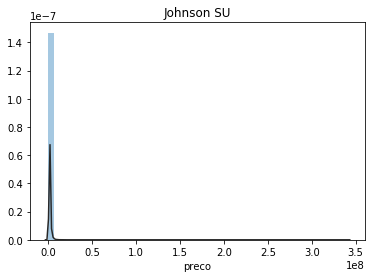

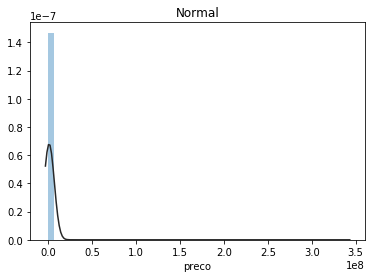

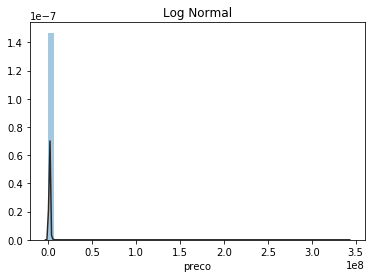

In [8]:
# Checking distribution
y = train['preco']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
plt.show()

É bem claro de se ver que há algo errado com a distribuição, ou seja, é provável que existam *outliers* no conjunto de dados. A fim de procurá-los, exibe-se o "*scatter plot*" dos preços.

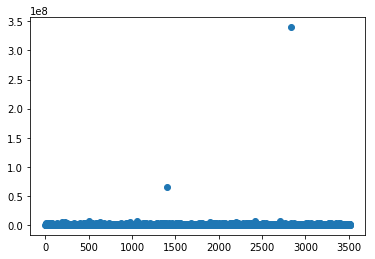

In [9]:
plt.scatter(range(0, len(train['preco'])), train['preco'])
plt.show()

Percebe-se que há três amostras bem acima das outras (preço >= 1e7). Para proceder, essas amostras serão removidas.

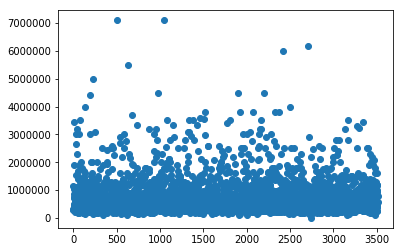

In [10]:
# Removing data for price above 1e7 (3 samples)
train = train.drop(train[train.preco > 1e7].index)

# Plotting scatter again
plt.scatter(range(0, len(train['preco'])), train['preco'])
plt.show()

Agora o conjunto parece coeso. Como foi verificado que há *outliers* no *dataset*, deseja-se encontrar outros. Para isso, exibem-se gráficos de "Preço" x "*feature*"

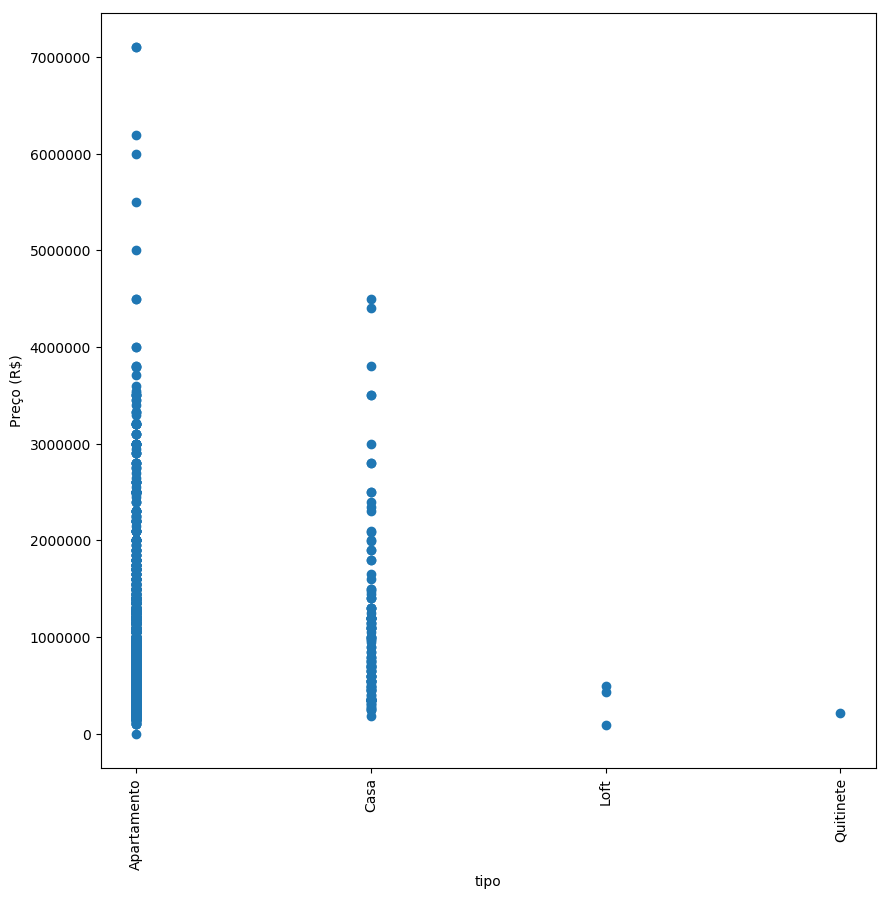

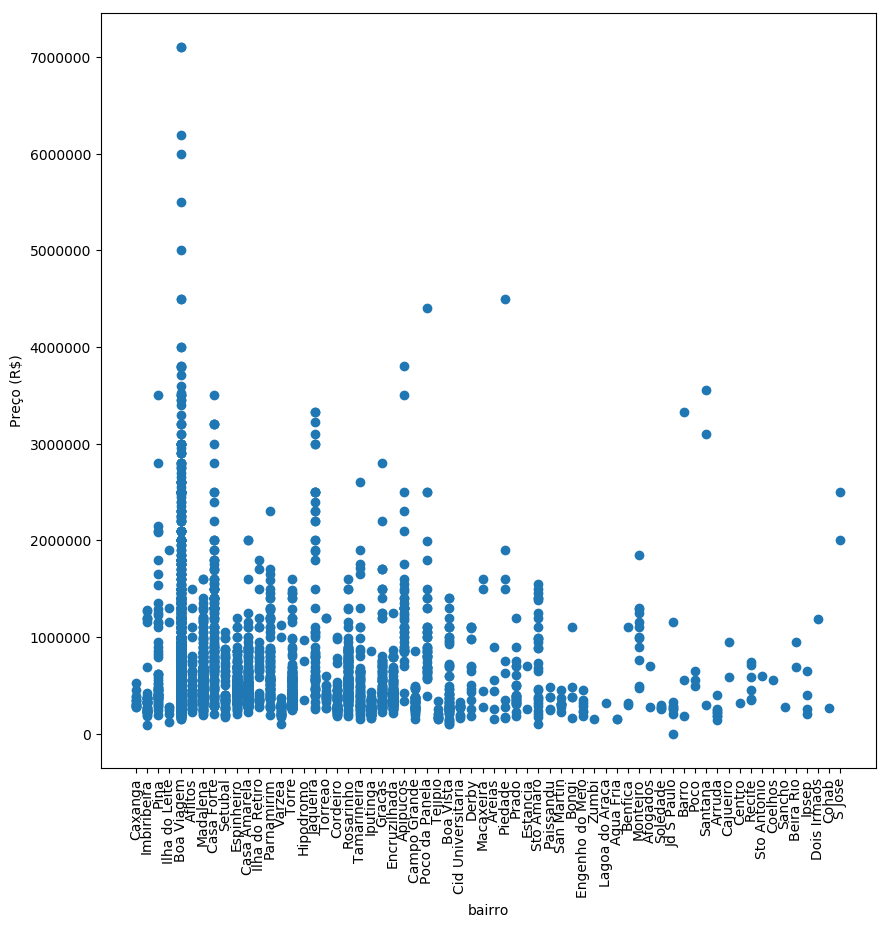

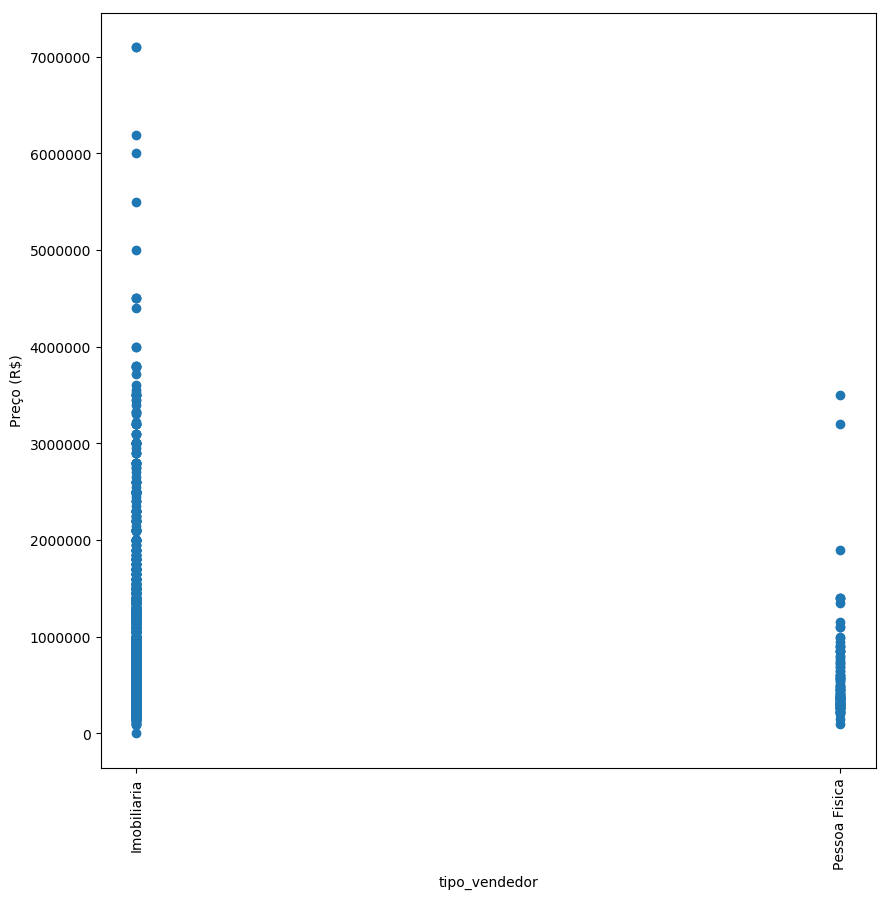

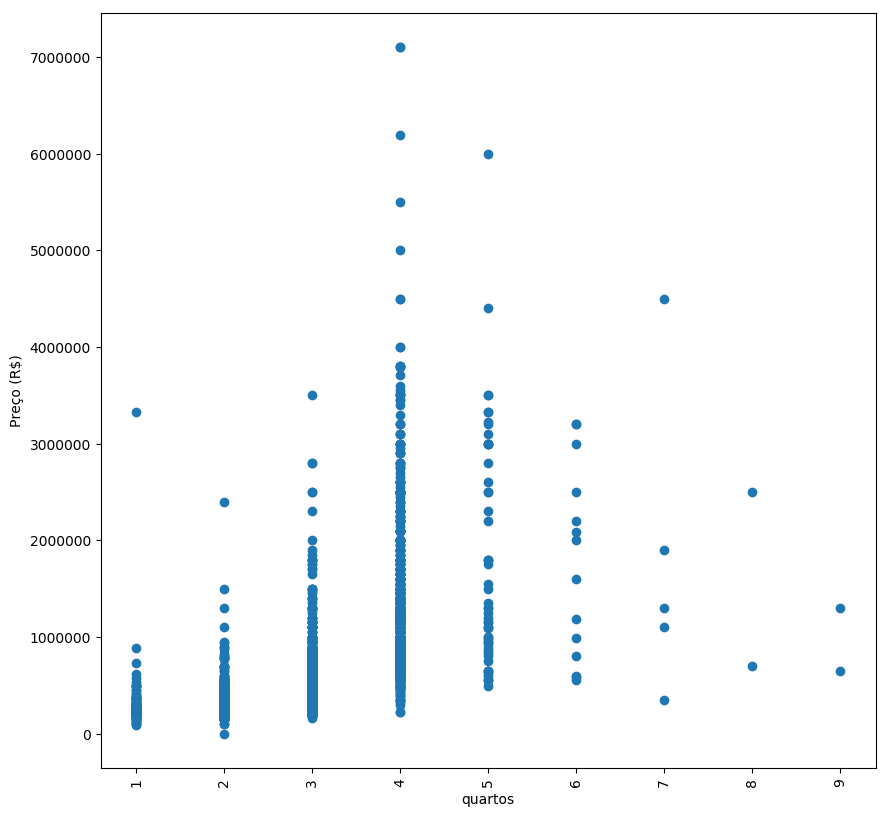

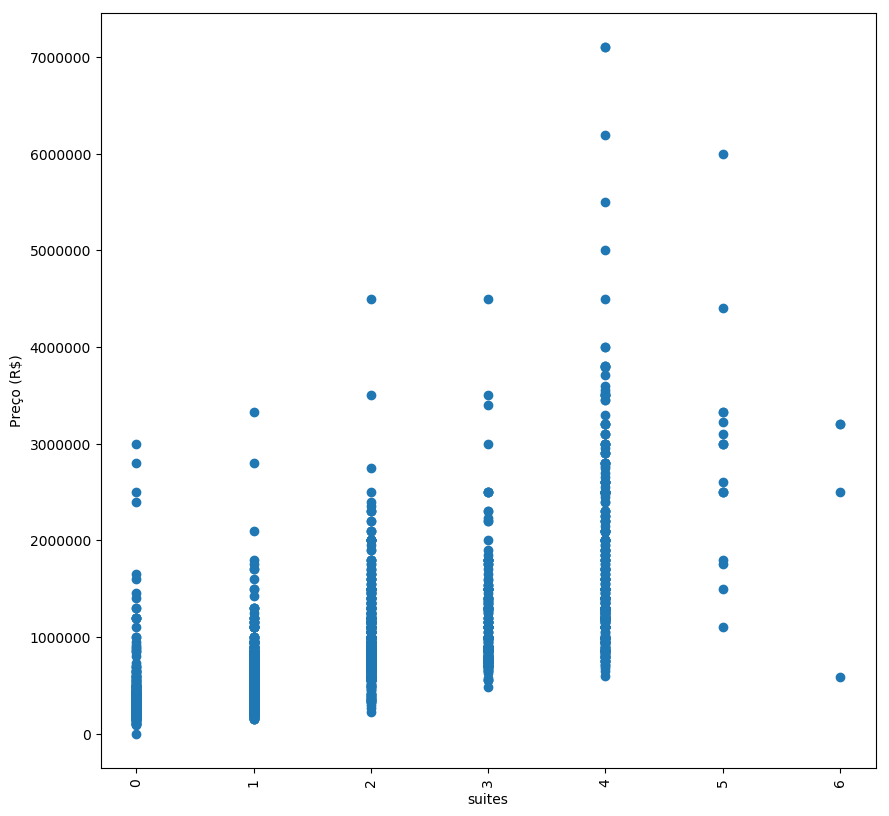

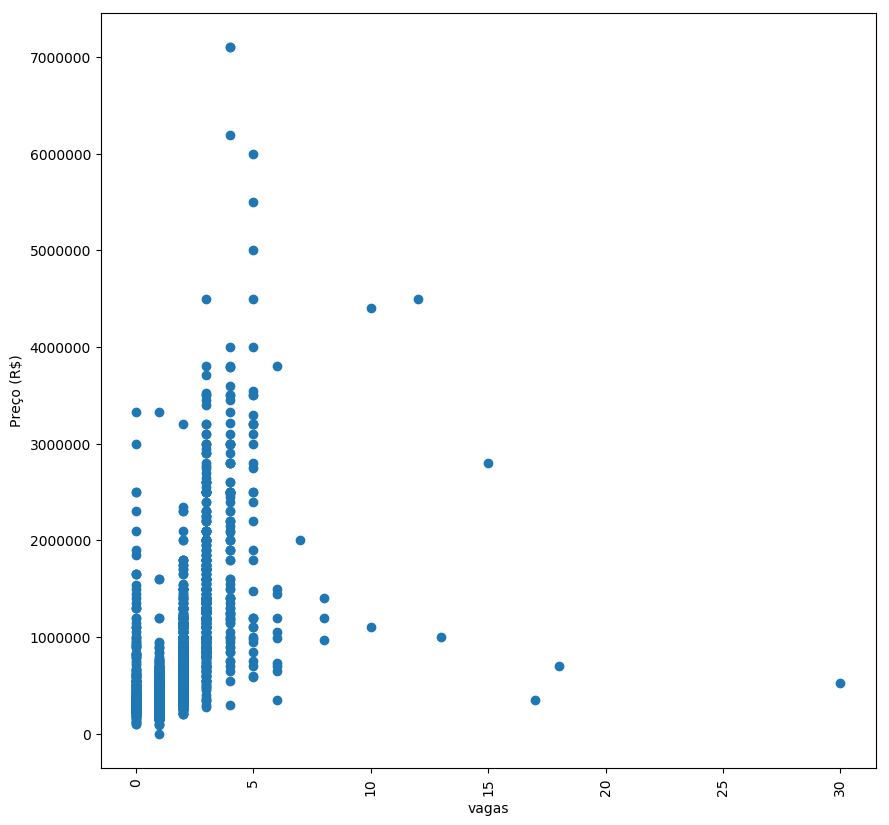

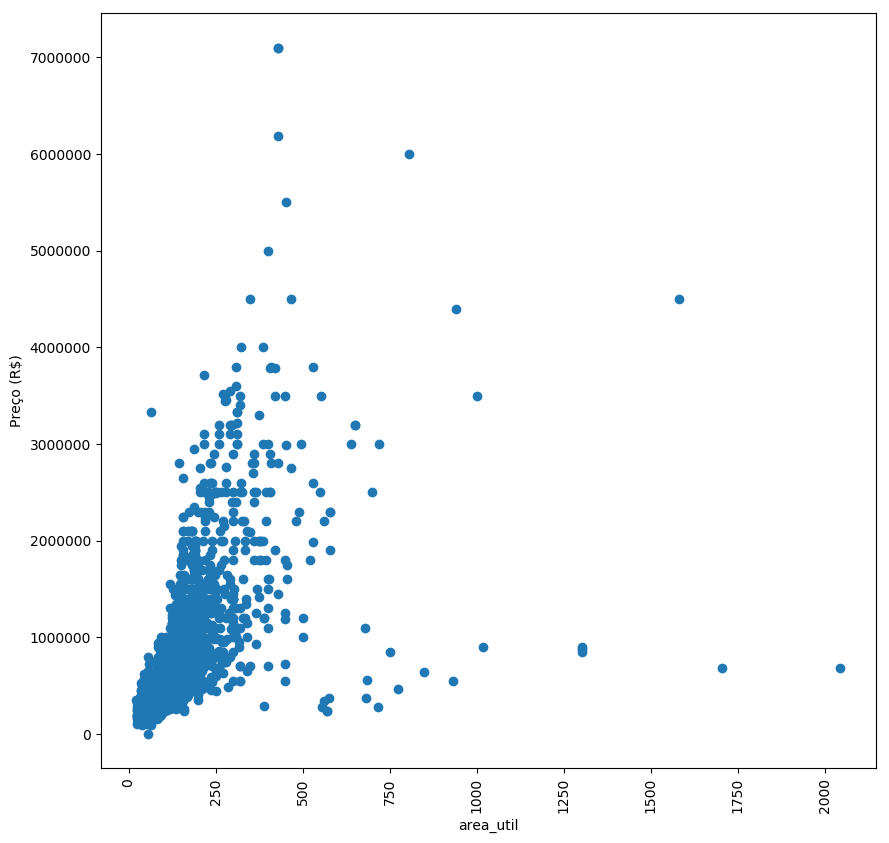

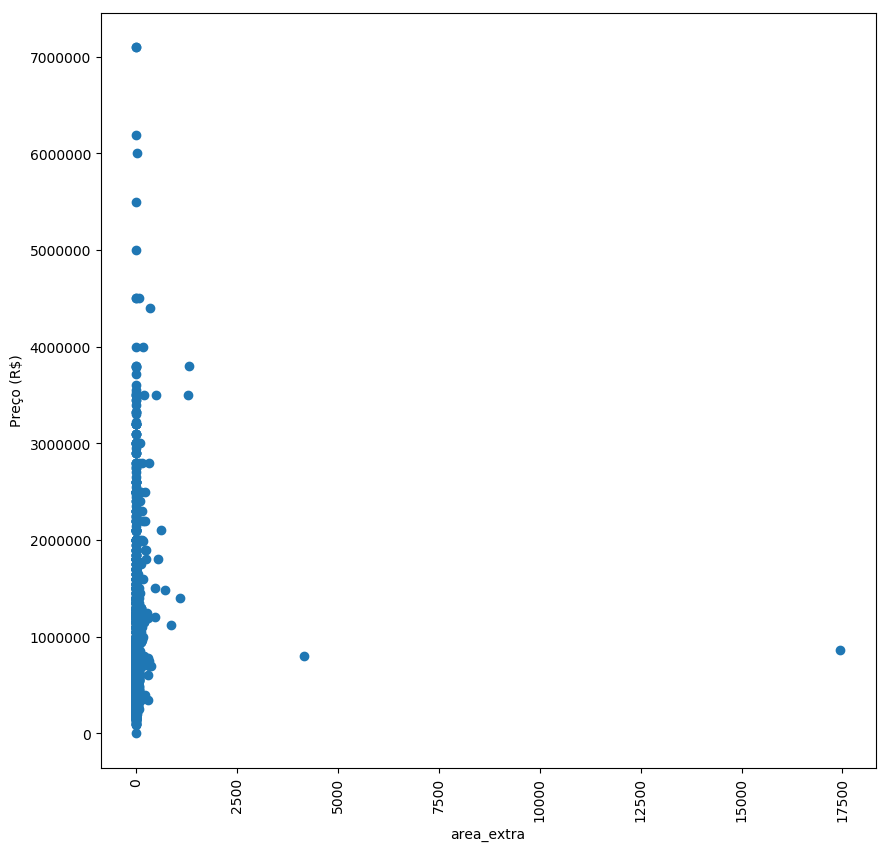

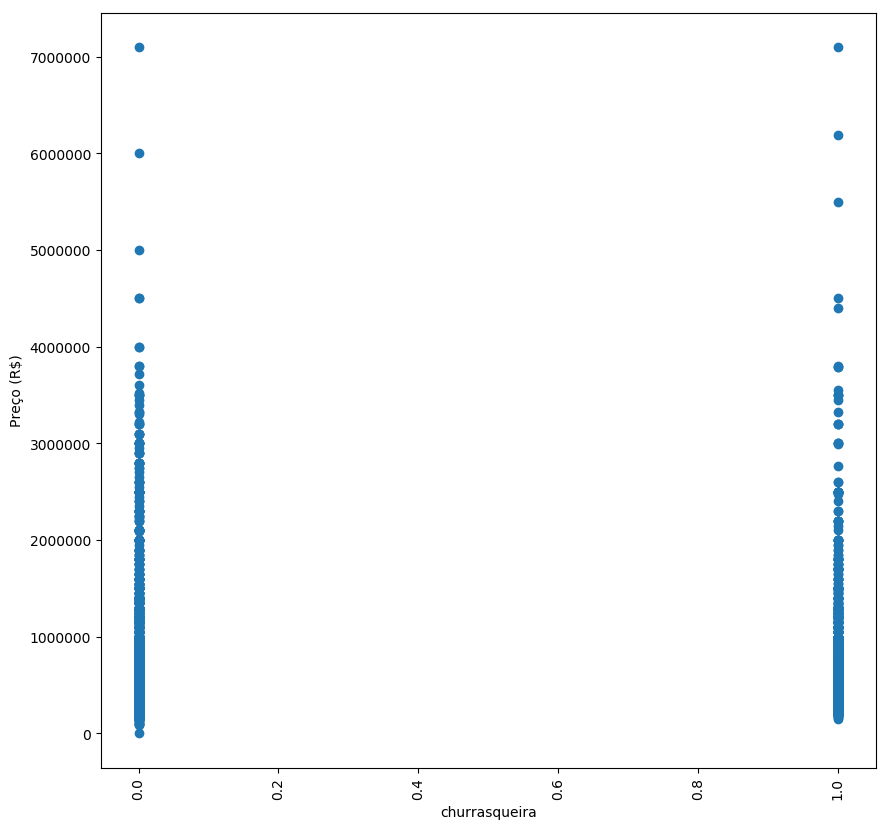

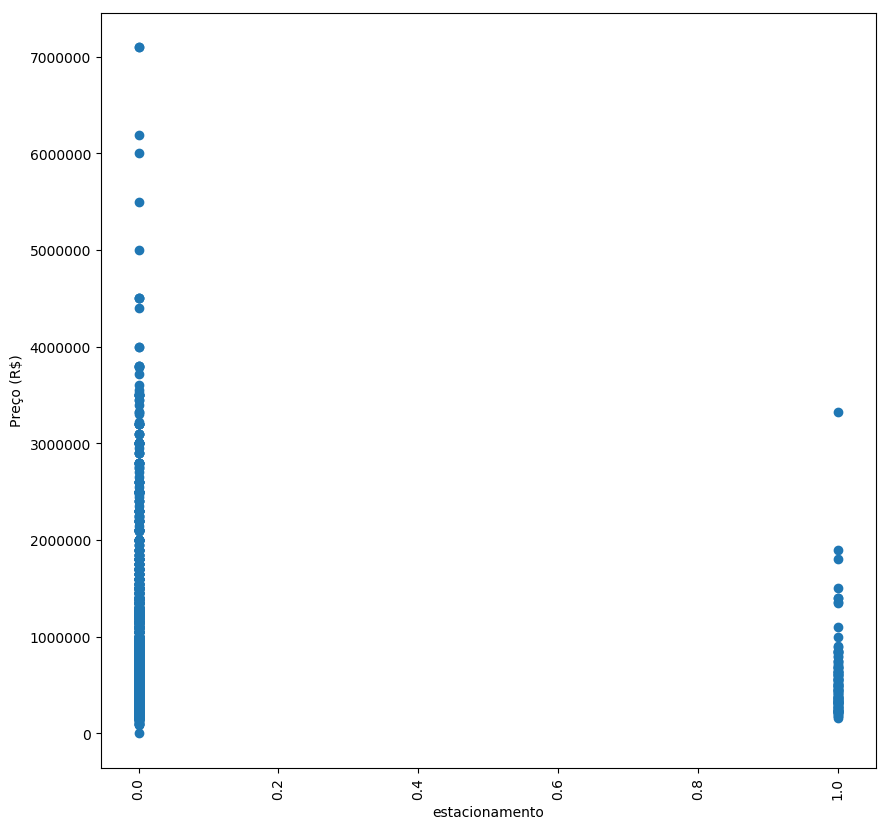

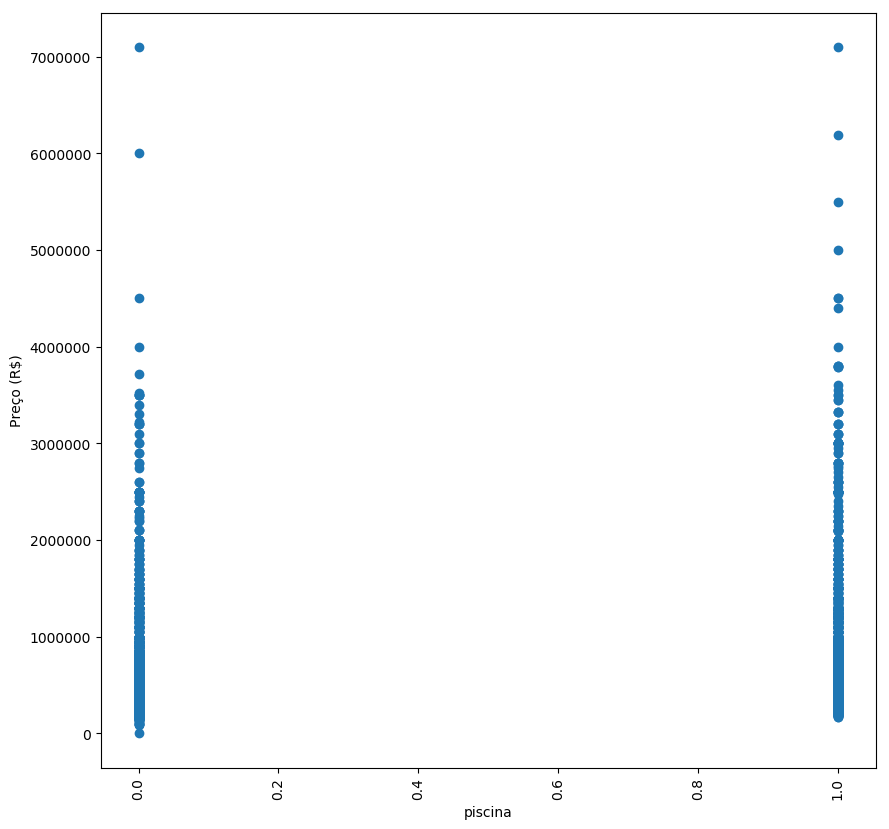

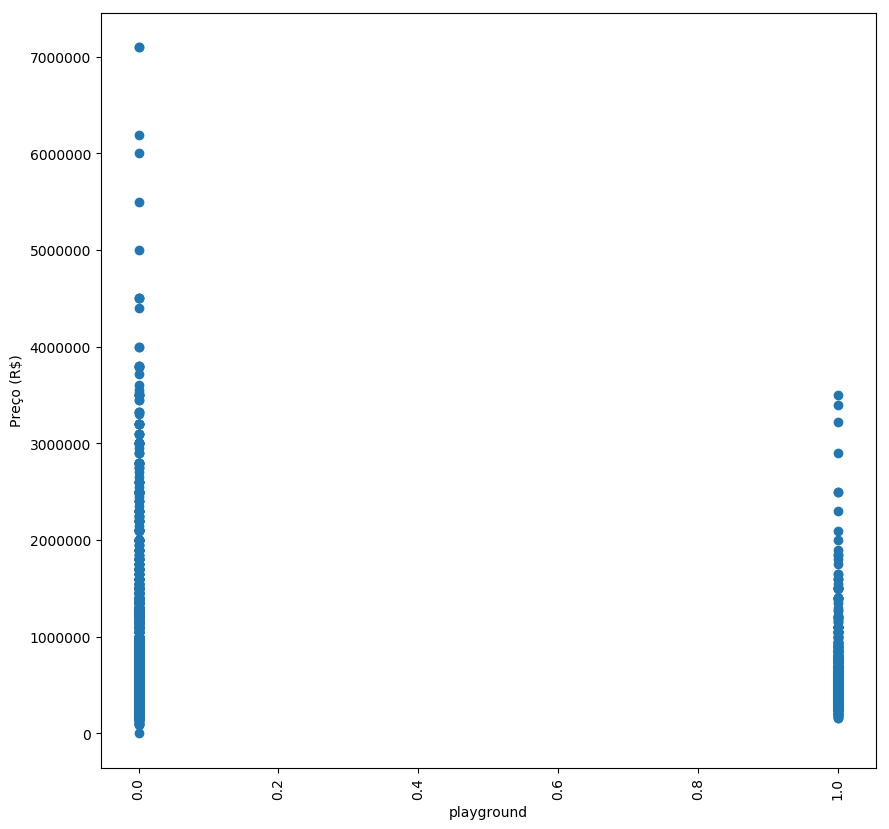

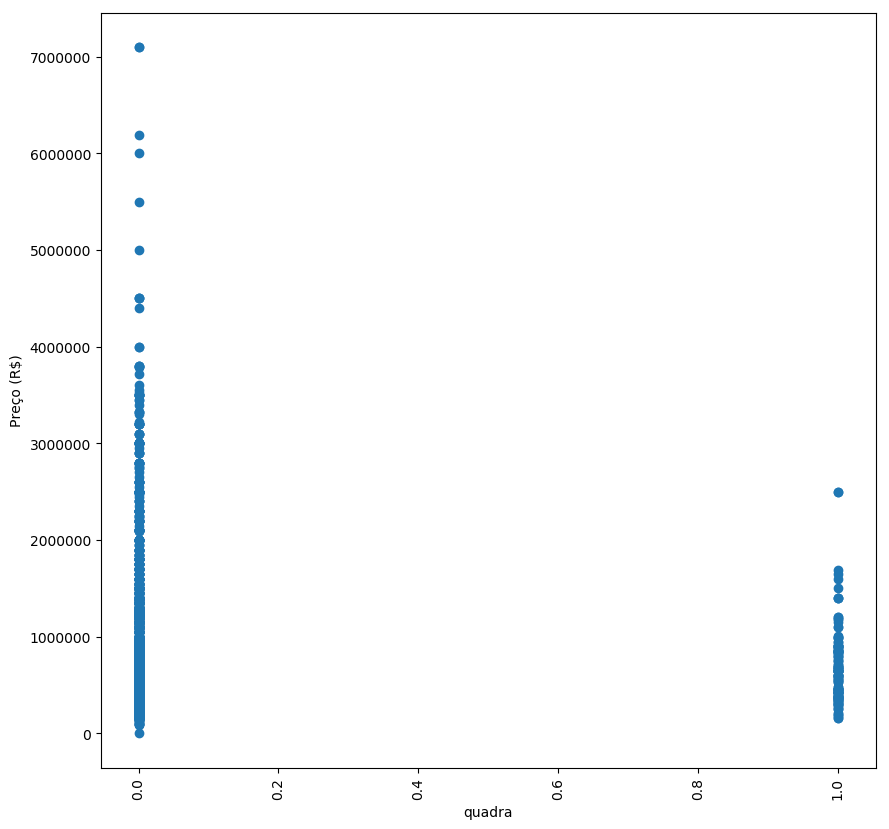

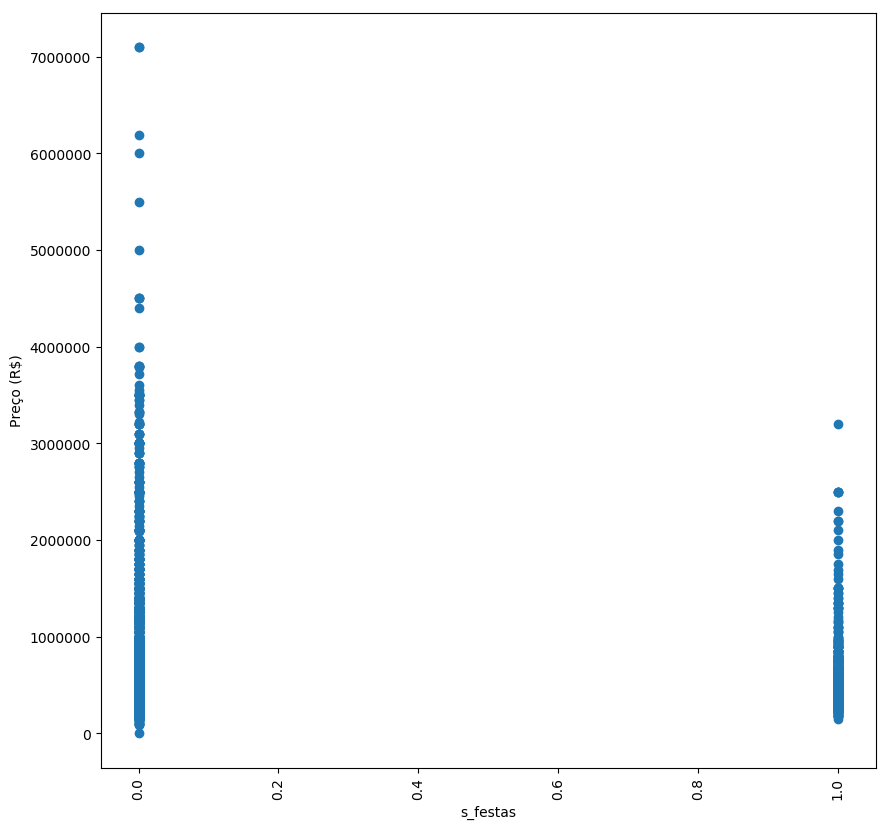

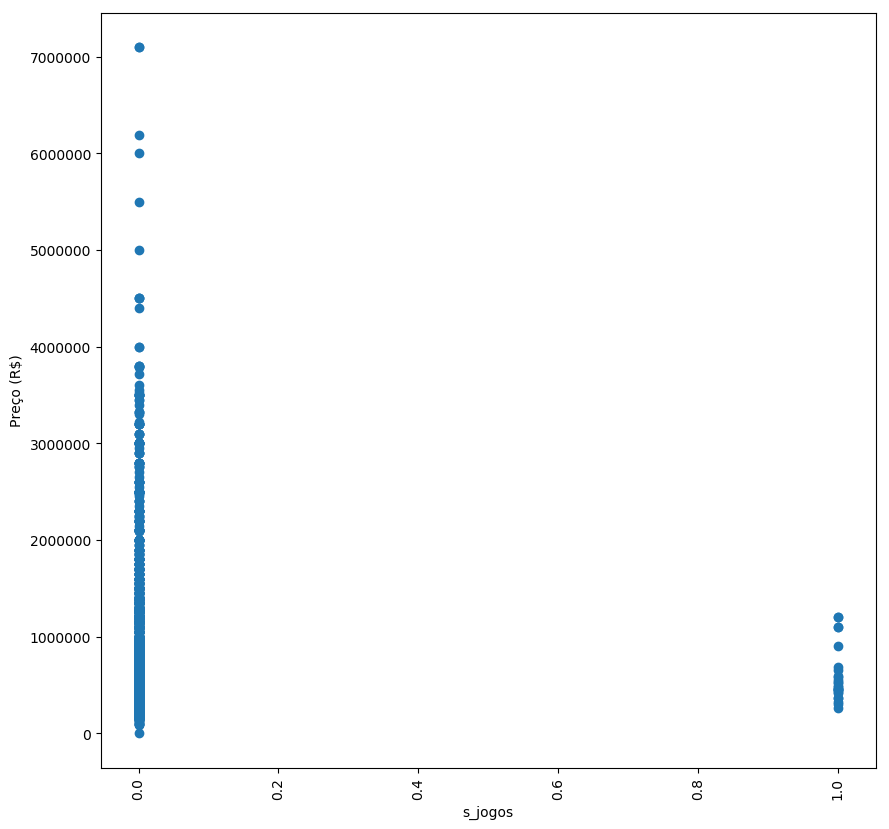

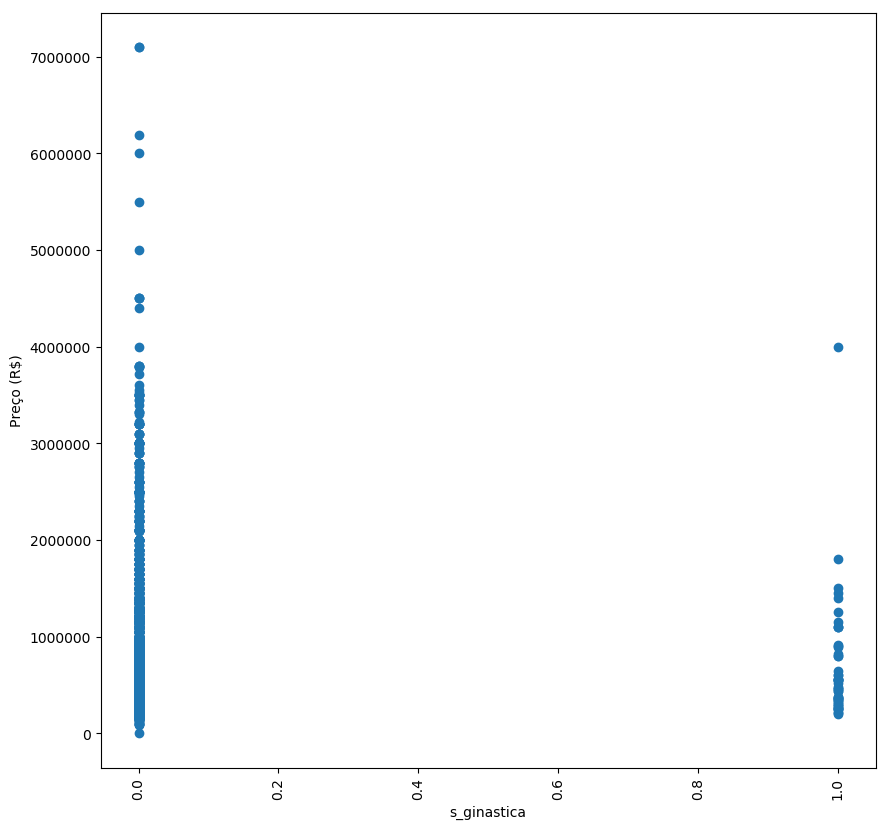

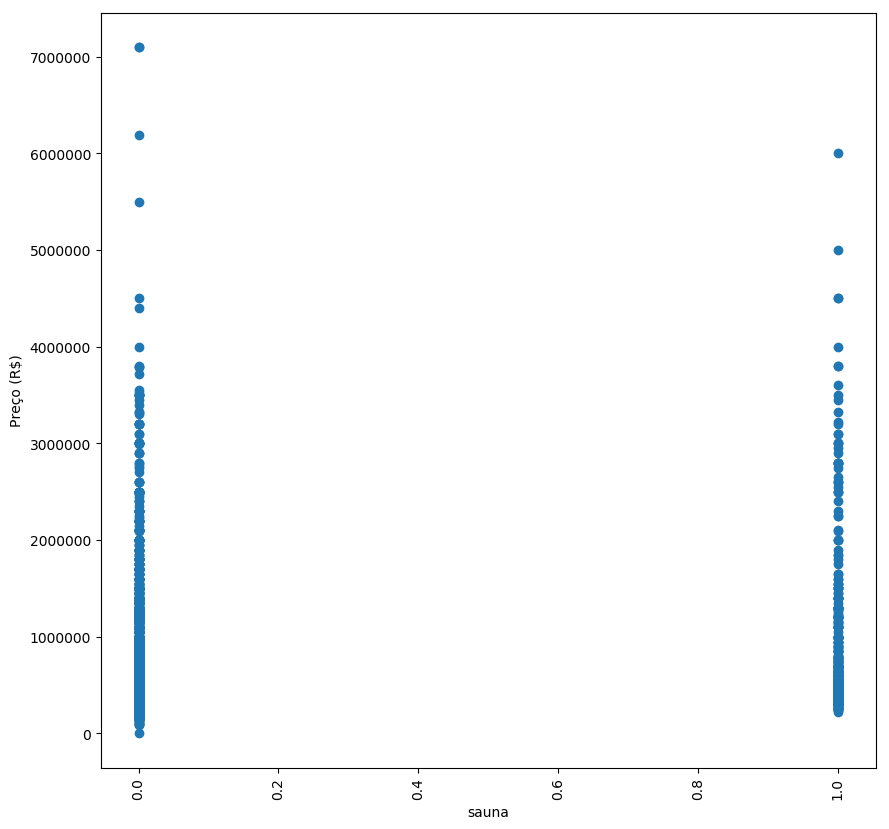

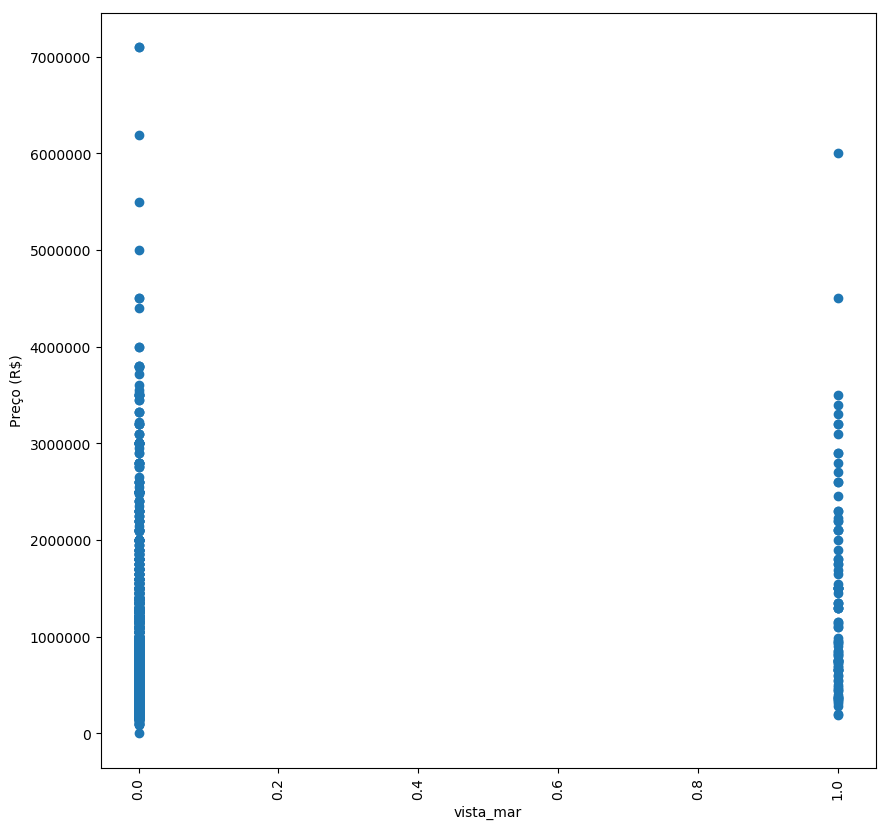

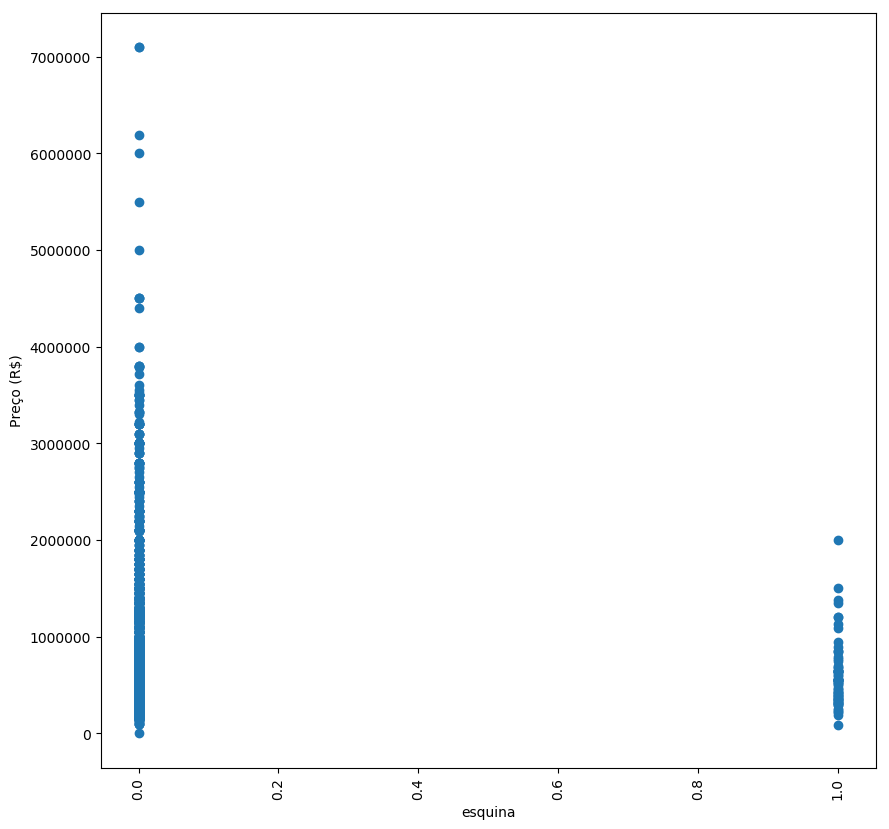

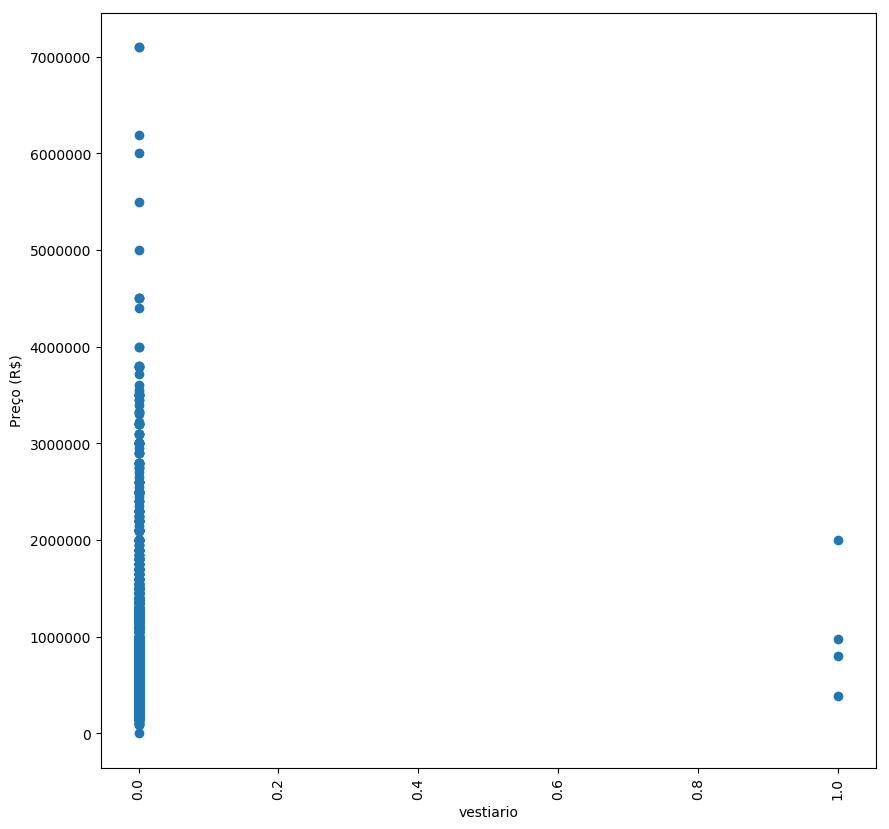

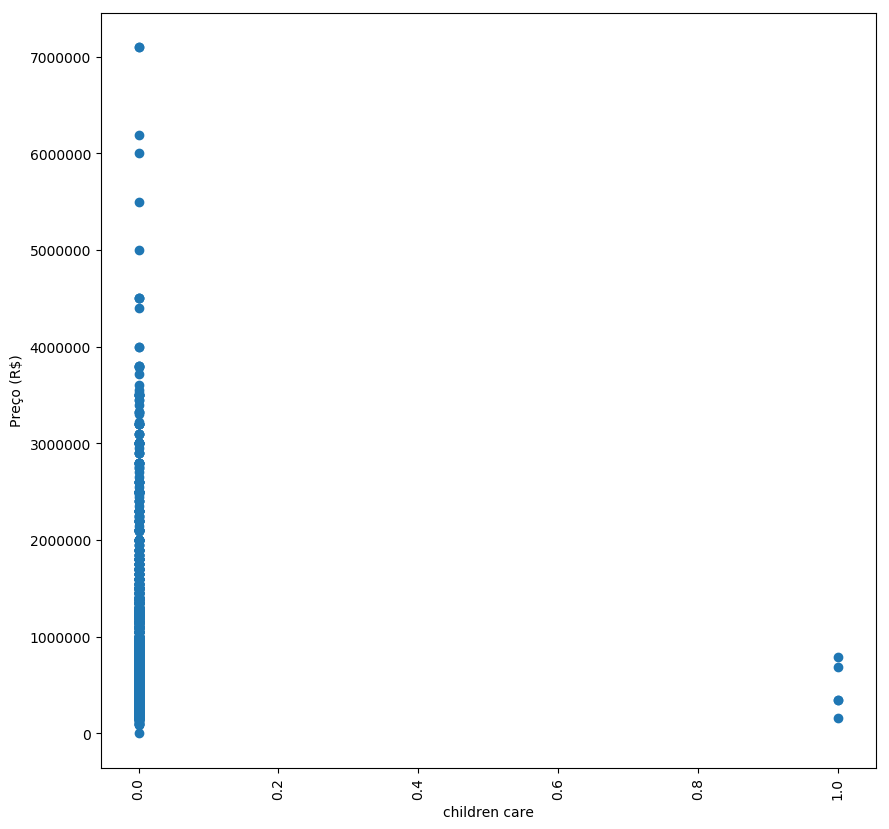

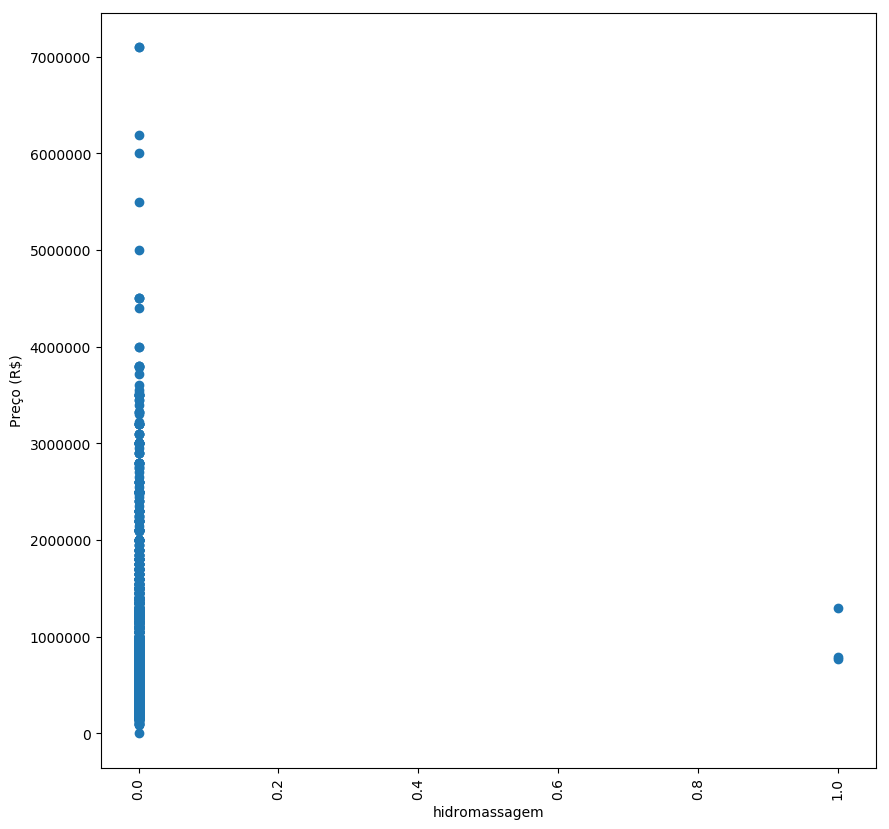

In [11]:
# Trying to find outliers plotting "preco" vs. <feature_name>
for feature in train:
    if feature != 'preco' and feature != 'Id':
        plt.figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
        plt.scatter(train[feature], train['preco'])
        plt.xlabel(feature)
        plt.xticks(rotation=90)
        plt.ylabel('Preço (R$)')
        plt.show()

Após a exibição desses gráficos, vê-se que há outros *outliers* a serem removidos. A remoção, então, será feita e, assim, pode-se proceder a análise dos dados.

In [12]:
# Removing outliers

# "Bairro" outliers
train = train.drop(train[(train.bairro == 'Piedade') & (train.preco >= 4e6)].index)

# "Quartos" outliers
train = train.drop(train[(train.quartos == 1) & (train.preco >= 3e6)].index)
train = train.drop(train[(train.quartos == 7) & (train.preco <= 1e6)].index)
train = train.drop(train[(train.quartos == 8) & (train.preco <= 2e6)].index)
train = train.drop(train[train.quartos == 9].index)

# "Suites" outliers
train = train.drop(train[(train.suites == 1) & (train.preco >= 5e6)].index)
train = train.drop(train[(train.suites == 6) & (train.preco <= 1e6)].index)

# "Vagas" outliers
train = train.drop(train[train.vagas > 10].index)

# "Área util" outliers
train = train.drop(train[(train.area_util >= 1250) & (train.preco <= 2e6)].index)

# "Área extra" outliers
train = train.drop(train[train.area_extra >= 2500].index)

# "Estacionamento" outliers
train = train.drop(train[(train.estacionamento == 1) & (train.preco >= 3e6)].index)

# "Quadra" outliers
train = train.drop(train[(train.quadra == 1) & (train.preco >= 4e6)].index)

# "S_Festas" outliers
train = train.drop(train[(train.s_festas == 1) & (train.preco >= 4e6)].index)

# "S_Ginastica" outliers
train = train.drop(train[(train.s_ginastica == 1) & (train.preco >= 3e6)].index)

# Plotting data again
#for feature in train:
#    if feature != 'preco' and feature != 'Id':
#        plt.figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#        plt.scatter(train[feature], train['preco'])
#        plt.xlabel(feature)
#        plt.xticks(rotation=90)
#        plt.ylabel('Preço (R$)')
#        plt.show()

Verifica-se, novamente, a distribuição do conjunto de treino.

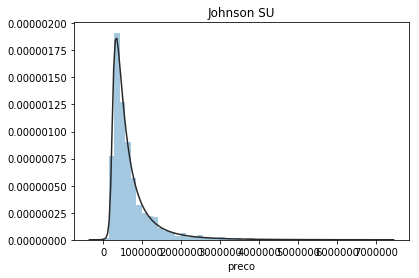

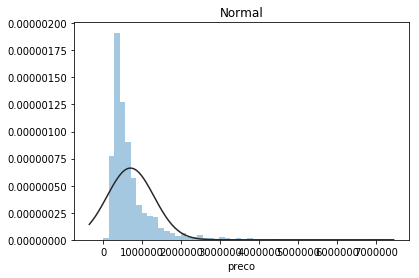

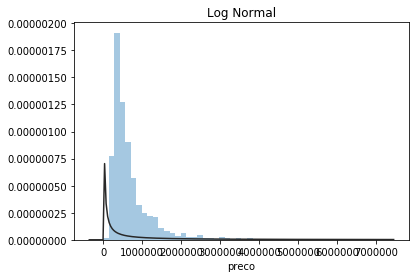

In [13]:
# Checking distribution again
y = train['preco']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Como, para o *fitting* em log(preco), há estranheza, exibe-se o *scatter plot* do mesmo, com intuito de encontrar *outliers*

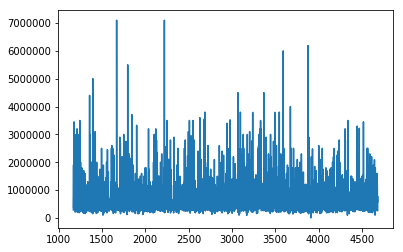

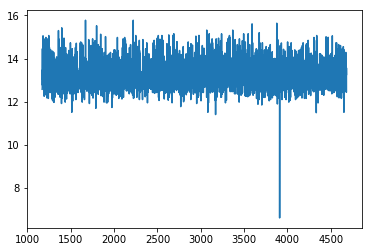

In [14]:
# Plotting prices
plt.plot(train['preco'])
plt.show()

# Plotting log(prices)
plt.figure()
plt.plot(np.log(train['preco']))
plt.show()

De fato há uma amostra que é um *outlier* em log(preço). Essa também será removida e verifica-se novamente a distribuição.

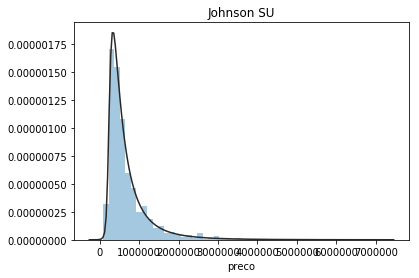

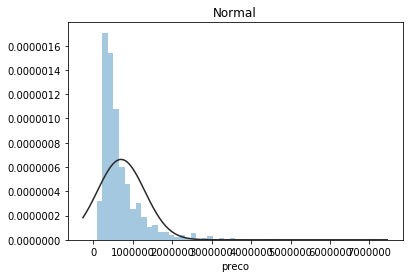

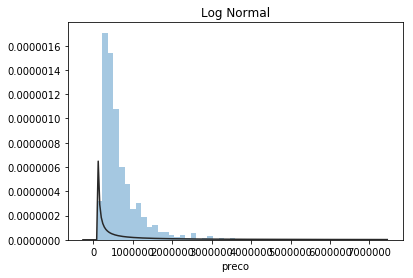

In [15]:
rel_min = np.min(np.log(train['preco']))
train = train.drop(train[np.log(train['preco']) == rel_min].index)

y = train['preco']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
plt.show()

Constata-se que os preços não seguem uma distribuição normal e o melhor *fitting* é o da distribuição de Johnson SU, portanto, a fim de aprimorar a questão da distribuição, trabalharemos com a coluna de preços transformada pela Transformada de Box-Cox, com *lambda = 0.25*. Abaixo exibe-se a distribuição antes e depois da transformação.

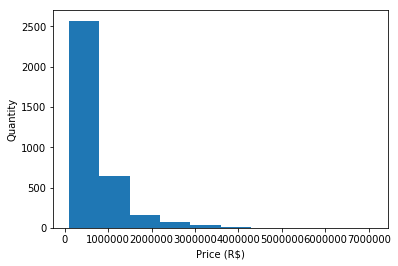

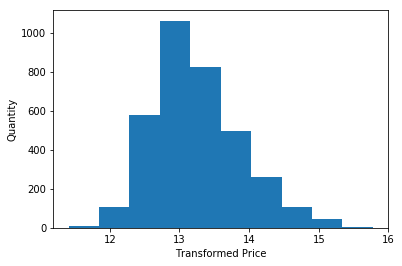

In [16]:
# Plotting bar chart before transformation
plt.figure()
plt.hist(train['preco'],orientation = 'vertical',histtype = 'bar')
plt.xlabel('Price (R$)')
plt.ylabel('Quantity')
plt.show()

# Plotting bar chart after log transformation
price_transform = boxcox1p(train['preco'], bclambda)

plt.figure()
plt.hist(price_transform, orientation = 'vertical',histtype = 'bar')
plt.xlabel('Transformed Price')
plt.ylabel('Quantity')
plt.show()

### Visualização de dados e correlações

Nessa subseção serão demonstradas algumas maneiras de visualizar os dados de nosso conjunto de treino, de maneira a adquirir alguns *insights*, se possível.

Um tipo de visualização julgada interessante foi, devido à característica geográfica da coluna "bairros", o *geographical heatmap*, de forma a tentar verificar uma relação entre a posição geográfica do imóvel e seu preço.

Para isso, listou-se todos os bairros pertencentes ao conjunto e constatou-se que o bairro "Poco" é nada além de uma referência para "Poco da Panela", onde substituiram-se esses valores pelos equivalentes. Da mesma forma identificou-se o bairro "Recife", que foi considerado como "Centro". O gráfico se encontra logo abaixo.

In [17]:
# Getting names for geographical heatmap
bairros = set()
for val in train['bairro']:
    bairros.add(val)
#print (sorted(bairros))

bairros_test = set()
for val in test['bairro']:
    bairros_test.add(val)
print ([i for i in bairros_test if i not in bairros])

# Mudando os valores de bairro de "poco" para "poco da panela" e de "recife" para "centro"
train.loc[train.bairro == 'Poco', 'bairro'] = 'Poco da Panela'
train.loc[train.bairro == 'Recife', 'bairro'] = 'Centro'
test.loc[test.bairro == 'Poco', 'bairro'] = 'Poco da Panela'
test.loc[test.bairro == 'Recife', 'bairro'] = 'Centro'
validation.loc[validation.bairro == 'Poco', 'bairro'] = 'Poco da Panela'
validation.loc[validation.bairro == 'Recife', 'bairro'] = 'Centro'

['Ibura', 'Fundao', 'Guabiraba', 'Beberibe']


In [18]:
# Gettind lat/lon data for geographical heatmap
geo_heatmap = {
    'Bairro' : ['Aflitos',
                'Afogados',
                'Agua Fria',
                'Apipucos',
                'Areias',
                'Arruda', 
                'Barro',
                'Beira Rio',
                'Benfica',
                'Boa Viagem',
                'Boa Vista', 
                'Bongi',
                'Cajueiro',
                'Campo Grande',
                'Casa Amarela',
                'Casa Forte',
                'Caxanga',
                'Centro',
                'Cid Universitaria',
                'Coelhos',
                'Cohab', 
                'Cordeiro',
                'Derby', 
                'Dois Irmaos',
                'Encruzilhada', 
                'Engenho do Meio',
                'Espinheiro',
                'Estancia',
                'Gracas',
                'Guabiraba',
                'Hipodromo',
                'Ilha do Leite',
                'Ilha do Retiro',
                'Imbiribeira', 
                'Ipsep',
                'Iputinga',
                'Jaqueira',
                'Jd S Paulo',
                'Lagoa do Araca',
                'Macaxeira',
                'Madalena',
                'Monteiro',
                'Paissandu',
                'Parnamirim',
                'Piedade',
                'Pina',
                'Poco da Panela',
                'Ponto de Parada', 
                'Prado', 
                'Rosarinho', 
                'S Jose',
                'San Martin',
                'Sancho',
                'Santana',
                'Setubal',
                'Soledade',
                'Sto Amaro',
                'Sto Antonio',
                'Tamarineira',
                'Tejipio',
                'Torre',
                'Torreao',
                'Varzea',
                'Zumbi',
                'Beberibe',
                'Ibura',
                'Fundao'
    ],
    
    'Latitude' : [
        -8.0397908,
        -8.0770326,
        -8.0149198,
        -8.019735,
        -8.0933832,
        -8.0251886,
        -8.1092715,
        -8.0485993,
        -8.0558827,
        -8.1317303,
        -8.0559795,
        -8.0655751,
        -8.0113561,
        -8.0321635,
        -8.0265163,
        -8.0335534,
        -8.026031,
        -8.0588241,
        -8.049515,
        -8.0681711,
        -8.1185361,
        -8.047818,
        -8.0561983,
        -8.0161786,
        -8.0372467,
        -8.0565421,
        -8.0431433,
        -8.0832795,
        -8.0451555,
        -7.9648352,
        -8.0325089,
        -8.0653267,
        -8.0649019,
        -8.1036898,
        -8.1073541,
        -8.0367128,
        -8.036285,
        -8.0809135,
        -8.0944109,
        -8.0131536,
        -8.0535802,
        -8.025565,
        -8.063771,
        -8.0334239,
        -8.0810772,
        -8.0941077,
        -8.0353286,
        -8.0296681,
        -8.0612599,
        -8.0331118,
        -8.0722973,
        -8.0710079,
        -8.0849483,
        -8.0405398,
        -8.1375557,
        -8.0564885,
        -8.0462309,
        -8.0649969,
        -8.0295954,
        -8.0895665,
        -8.045011,
        -8.039835,
        -8.0481699,
        -8.0529718,
        -8.0047804,
        -8.1101563,
        -8.0149872
    ],
    'Longitude' : [
        -34.896209,
        -34.9091753,
        -34.8968235,
        -34.9357679,
        -34.9315393,
        -34.8935035,
        -34.954419,
        -34.9058245,
        -34.9058967,
        -34.902409,
        -34.8953473,
        -34.9180396,
        -34.8858658,
        -34.881336,
        -34.9177915,
        -34.9189597,
        -34.9527201,
        -34.8820243,
        -34.9503969,
        -34.8893137,
        -34.954732,
        -34.9284596,
        -34.8996565,
        -34.9452495,
        -34.8909859,
        -34.9437716,
        -34.8913824,
        -34.9299881,
        -34.9020596,
        -34.9228915,
        -34.8879346,
        -34.89483,
        -34.9051721,
        -34.9107585,
        -34.923195,
        -34.9352704,
        -34.9037314,
        -34.9432807,
        -34.9150252,
        -34.9291854,
        -34.9087328,
        -34.9299881,
        -34.898967,
        -34.9103805,
        -34.9428025,
        -34.8855697,
        -34.924474,
        -34.893451,
        -34.9127452,
        -34.8974905,
        -34.8840889,
        -34.9287891,
        -34.9603088,
        -34.9158124,
        -34.908504,
        -34.8906928,
        -34.878635,
        -34.880349,
        -34.9003716,
        -34.9603088,
        -34.9099178,
        -34.8837971,
        -34.9590198,
        -34.916796,
        -34.8962354,
        -34.9365967,
        -34.8901232
    ]
}

train_bairros = set(train['bairro'].tolist())

geo_dataframe = pd.DataFrame.from_dict(geo_heatmap)

geo_dataframe = geo_dataframe[geo_dataframe['Bairro'].isin(train_bairros)]

geo_dataframe["price"] = pd.Series(train.groupby(["bairro"]).mean()["preco"].values, index = geo_dataframe.index)

import folium
from folium.plugins import HeatMap
max_amount = float(geo_dataframe['price'].max())
hmap = folium.Map(location = [-8.1, -35], zoom_start = 12)
hm_wide = HeatMap (list (zip (geo_dataframe.Latitude.values, geo_dataframe.Longitude.values, geo_dataframe.price.values)),
                   min_opacity = 0.4,
                   max_val = max_amount,
                       radius = 17,
                   blur = 15,
                   max_zoom = 1
                  )
hmap.add_child(hm_wide)

Uma correlação entre as coordenadas geográficas dos bairros e seus preços médios não é tão intuitiva. Dessa maneira, serão incluídas colunas com valores referentes às latitudes e longitudes de cada um.

In [ ]:
# Building auxiliar dicts
lat_dict = {}
lon_dict = {}
for i in range(len(geo_heatmap['Bairro'])):
    bairro = geo_heatmap['Bairro'][i]
    lat = geo_heatmap['Latitude'][i]
    lon = geo_heatmap['Longitude'][i]
    lat_dict[bairro] = lat
    lon_dict[bairro] = lon

# Method that adds latitude and longitude columns
def add_lat_lon_columns (df):
    df ['lat'] = df['bairro'].map(lat_dict)
    df ['lon'] = df['bairro'].map(lon_dict)
    
# Adding columns to train and test sets
add_lat_lon_columns(train)
add_lat_lon_columns(test)
add_lat_lon_columns(validation)

Também julgou-se interessante o entendimento das correlações entre as *features* categóricas e o preço, a partir dos gráficos abaixo

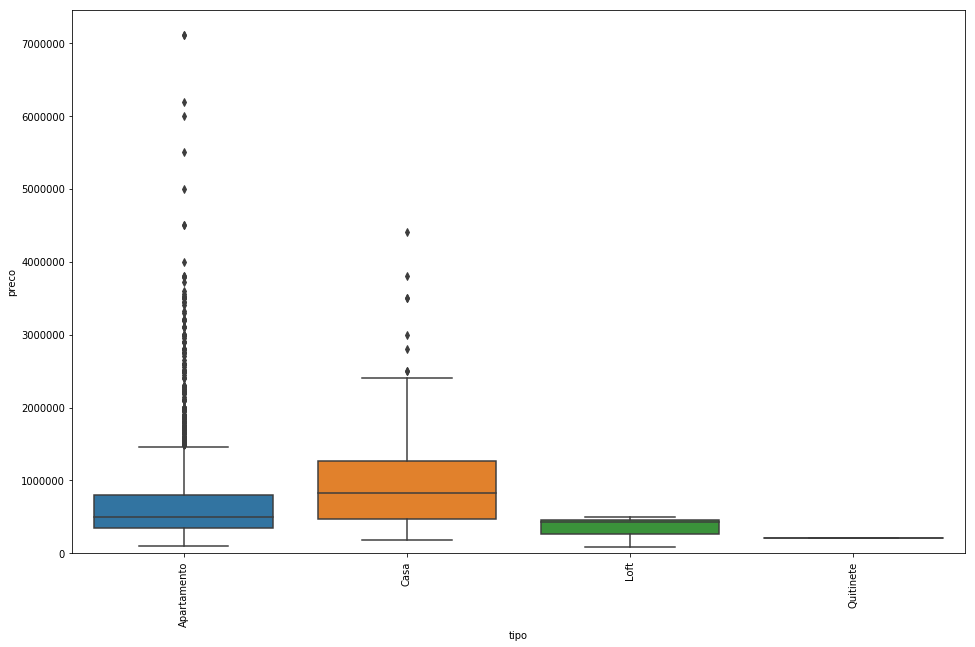

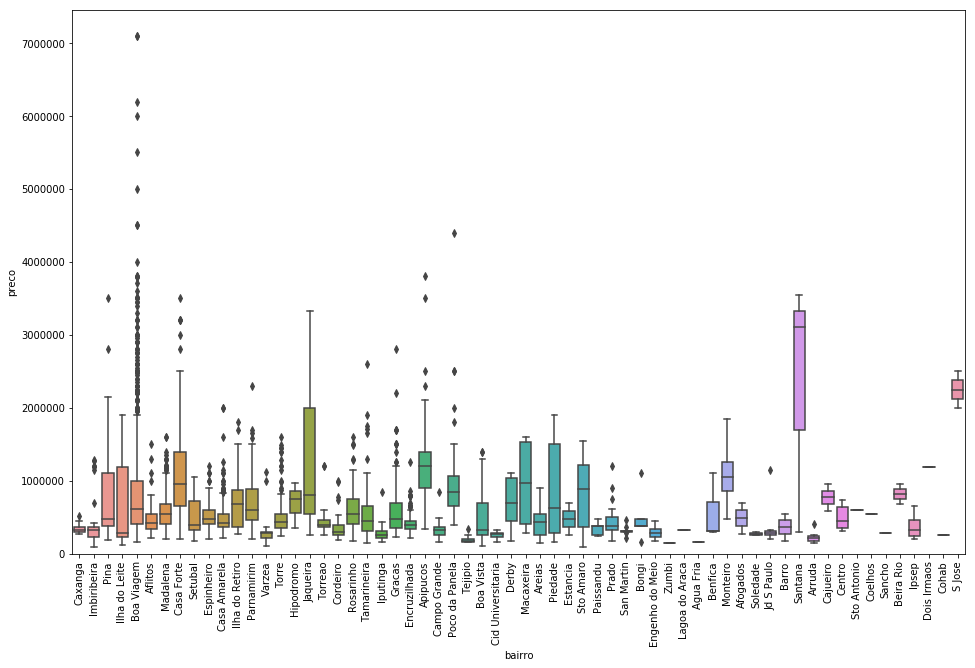

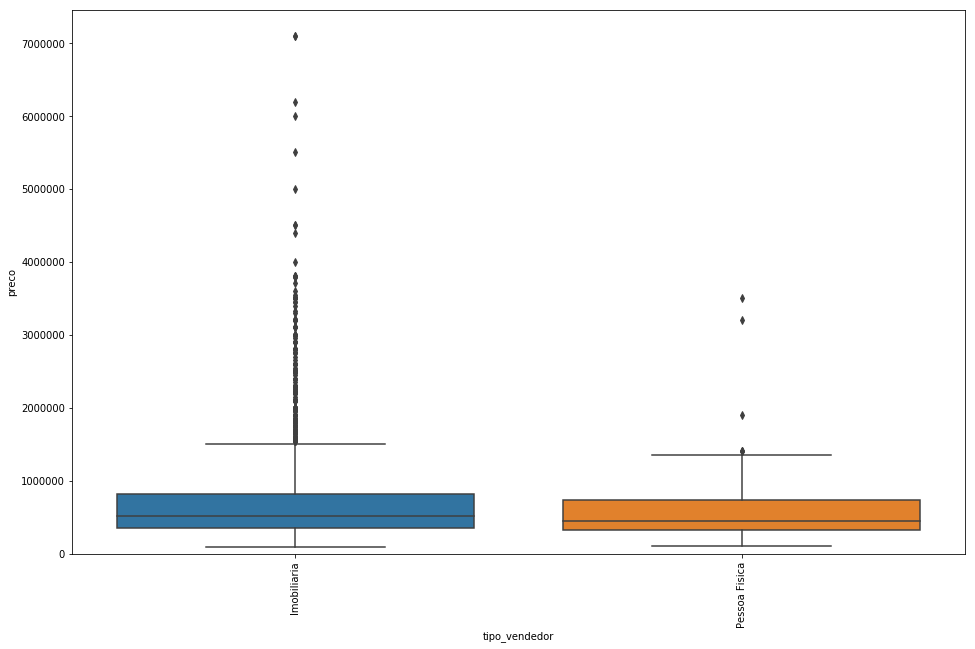

In [ ]:
# Understanding correlations between categorical features and the price
categorical_features = train.select_dtypes(include=[np.object])

columns = [i for i in categorical_features if i != 'Id']
for var in columns:
    data = pd.concat([train['preco'], train[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 10))
    fig = sns.boxplot(x=var, y="preco", data=data)
    fig.axis(ymin=0);
    xt = plt.xticks(rotation=45)
    plt.xticks(rotation=90)
    plt.show()

Antes de trabalhar com as variáveis numéricas, será feita a normalização de todas.

In [ ]:
def normalize_data (df, numeric_features):
    for column in numeric_features:
        if column == 'lat' or column == 'lon':
            df[column] = df[column] / df[column].max()
        df[column] = df[column] / df[column].max()

numeric_features = [i for i in train.select_dtypes(include=[np.number]) if (i != 'Id') and (i != 'preco')]

normalize_data (train, numeric_features)
normalize_data (test, numeric_features)

Após a normalização, serão calculados os índices de correlação entre as variáveis numéricas e exibidas as que tiverem correlação positiva.

In [ ]:
# Finding correlation between price and numeric features
correlation = train.corr()

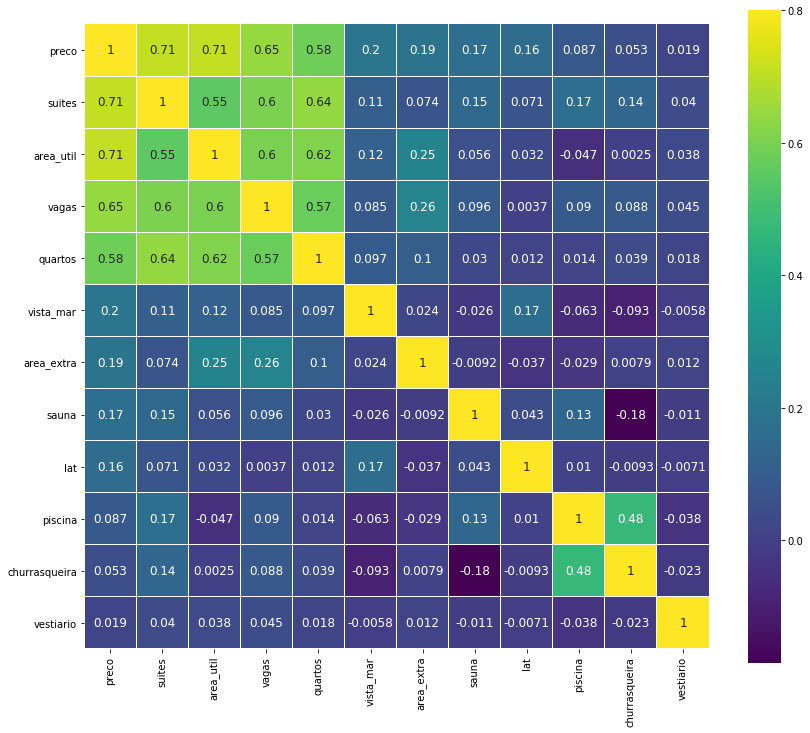

In [ ]:
# Heatmap of positive correlation features
k = len([i for i in correlation['preco'] if abs(i) >= 0.05])
cols = correlation.nlargest(k,'preco')['preco'].index
cm = np.corrcoef(train[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)
plt.show()

Serão exibidos também gráficos par a par dos *features* numéricos e a tentativa de uma função linear que concorde com a tendência dos dados

/home/jovyan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


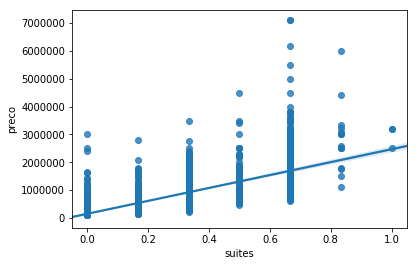

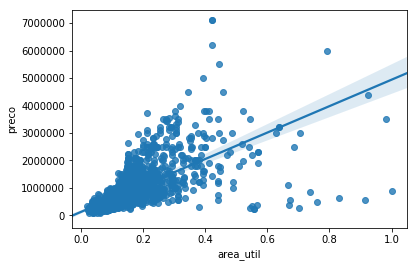

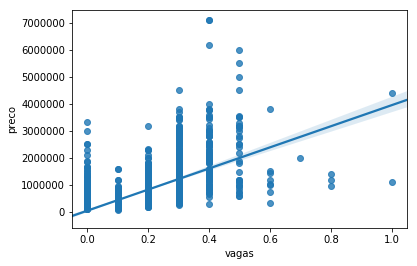

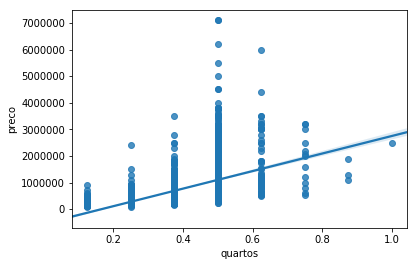

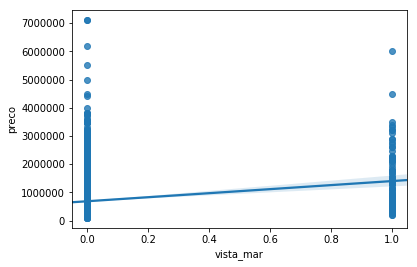

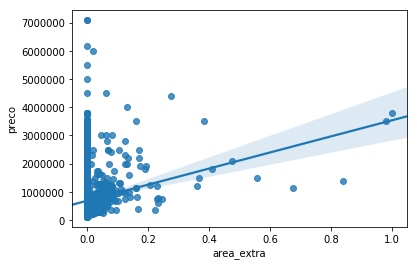

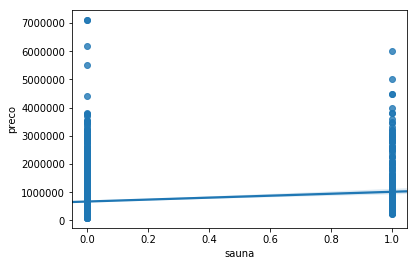

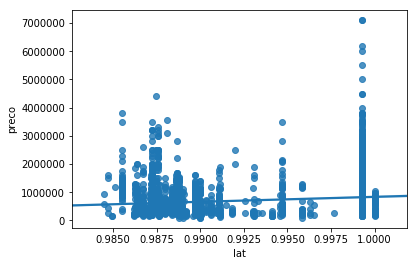

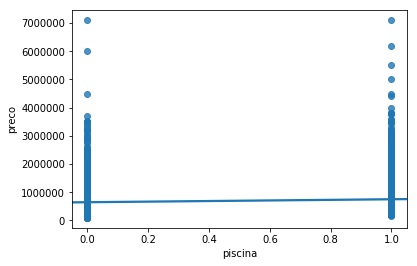

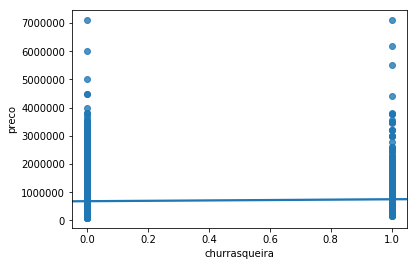

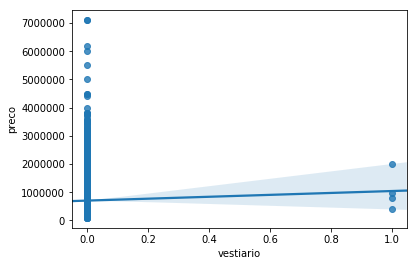

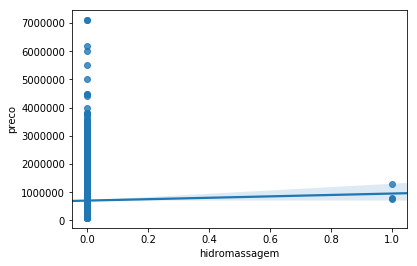

In [ ]:
# Pair plotting in order to understand better correlation by fitting a simple linear
corr_preco = correlation['preco']
corr_series = corr_preco[corr_preco > 0].sort_values(ascending = False)

series_labels = list(corr_series.index)

for feature in series_labels[1:]:
    if (feature != 'Id'):
        plt.figure()
        scatter_plot = pd.concat([train['preco'], train[feature]], axis = 1)
        sns.regplot(x = feature, y = 'preco', data = scatter_plot, scatter = True, fit_reg = True)
        plt.show()

## Selecionando *features* e fazendo predições

Nessa seção serão abordados os métodos utilizados para seleção de *features* e realização de predições de acordo com os dados de teste.

De início, algumas bibliotecas úteis foram inclusas, delas:
* *sklearn* com utilidades de aprendizado de máquina e implementação de alguns modelos de regressão;
* *xgboost* para implementação da regressão com XGBoost;
* *warnings* para filtragem de avisos;
* *scipy* com utilidades do ramo da estatística.

In [ ]:
# Imports
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,Lasso,SGDRegressor,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder,Imputer,OneHotEncoder,RobustScaler,StandardScaler,Imputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,VotingClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.base import BaseEstimator,clone,TransformerMixin,RegressorMixin
from sklearn.svm import LinearSVR,SVR
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.stats.stats import pearsonr

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Começa-se avaliando a quantidade de categorias que cada atributo categórico possui.

In [ ]:
# Evaluating unique categories in train and test dataframes
for column_name in train.columns:    
    if train[column_name].dtypes == 'object':
        unique_category = len(train[column_name].unique())
        print("Feature '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name,
                                                                                         unique_category=unique_category))

for column_name in test.columns:
    if test[column_name].dtypes == 'object':
        unique_category = len(test[column_name].unique())
        print("Features in test set '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name, unique_category=unique_category))

Feature 'tipo' has '4' unique categories
Feature 'bairro' has '62' unique categories
Feature 'tipo_vendedor' has '2' unique categories
Features in test set 'tipo' has '3' unique categories
Features in test set 'bairro' has '56' unique categories
Features in test set 'tipo_vendedor' has '2' unique categories


A fim de avaliar e manipular de maneira mais eficiente os conjuntos de dados, uniu-se ambos os conjuntos de treino e teste, excluindo as colunas de 'Id' e 'Preço'.

In [ ]:
# Joining train and test data, in order to ease the preprocessing
full = pd.concat([train, test, validation], ignore_index = True)
#full.drop('Id', axis = 1, inplace = True)
full.drop(['preco'], axis=1, inplace=True)

Verifica-se agora se há algum dado faltante nas colunas de *full*, que é a união dos conjuntos de treino e teste.

In [ ]:
# Checking for missing values
missing_values = full.isnull().sum()
missing_values[missing_values>0].sort_values(ascending = False)

full[full.isnull().any(axis=1)].head()

,Id,area_extra,area_util,bairro,children care,churrasqueira,esquina,estacionamento,hidromassagem,lat,...,s_festas,s_ginastica,s_jogos,sauna,suites,tipo,tipo_vendedor,vagas,vestiario,vista_mar


Uma vez que não há valores faltantes, será feito agora o *encoding* dos atributos categóricos.

In [ ]:
# Checking numeric features
numeric_features = full.select_dtypes(include=[np.number]).drop('Id', axis = 1, inplace = True)
#numeric_features.columns

Será feito encoding com *one-hot*, ou seja, haverá uma coluna para cada categoria e, a partir disso, será possível colocar o valor *1* para verdadeiro e *0* para falso.

In [ ]:
# One hot encoding
full = pd.get_dummies(full)

Após o *encoding*, será feita a separação dos dados novamente para treino e teste.

Com a separação realizada, os dados serão colocados em escala e serão transformados pela Análise dos Componentes Principais, que gerará *features* posteriormente utilizados.

In [ ]:
# Separating train and test data
train_Ids = set(train['Id'].tolist())
test_Ids = set(test['Id'].tolist())
valid_Ids = set(validation['Id'].tolist())

X_train = full[full['Id'].isin(train_Ids)]
X_train.drop('Id', axis = 1, inplace = True)
y_train = train.preco

print ("Shape of X_train: {}".format(X_train.shape))

X_test = full[full['Id'].isin(test_Ids)]
X_test.drop('Id', axis = 1, inplace = True)

print ("Shape of X_test: {}".format(X_test.shape))

X_valid = full[full['Id'].isin(valid_Ids)]
X_valid.drop('Id', axis = 1, inplace = True)

print ("Shape of X_valid: {}".format(X_valid.shape))

# Scaling data
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit(X_train).transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

y_train_transformed = boxcox1p(train.preco, bclambda)

Shape of X_train: (3489, 94)
Shape of X_test: (2000, 94)
Shape of X_valid: (1170, 94)


Antes de iniciar os testes, a função de erro médio quadrático deve ser definida, de forma a comparar os modelos.

In [ ]:
# Define Root Mean Square Error w/ Cross-validation 
def rmse_cv (model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5))
    return rmse

# Define Pure Root Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse (y_actual, y_predicted):
     return sqrt(mean_squared_error(y_actual, y_predicted))

Será feito agora um estudo para escolha de *features* baseando-se no "*Feature importance*" do *XGBoost Regressor*, que considera o número de vezes que um atributo aparece na árvore, e também por eliminação recursiva de *feature* e seleção por validação cruzada.

Abaixo inicia-se a análise com o *XGBoost Regressor*

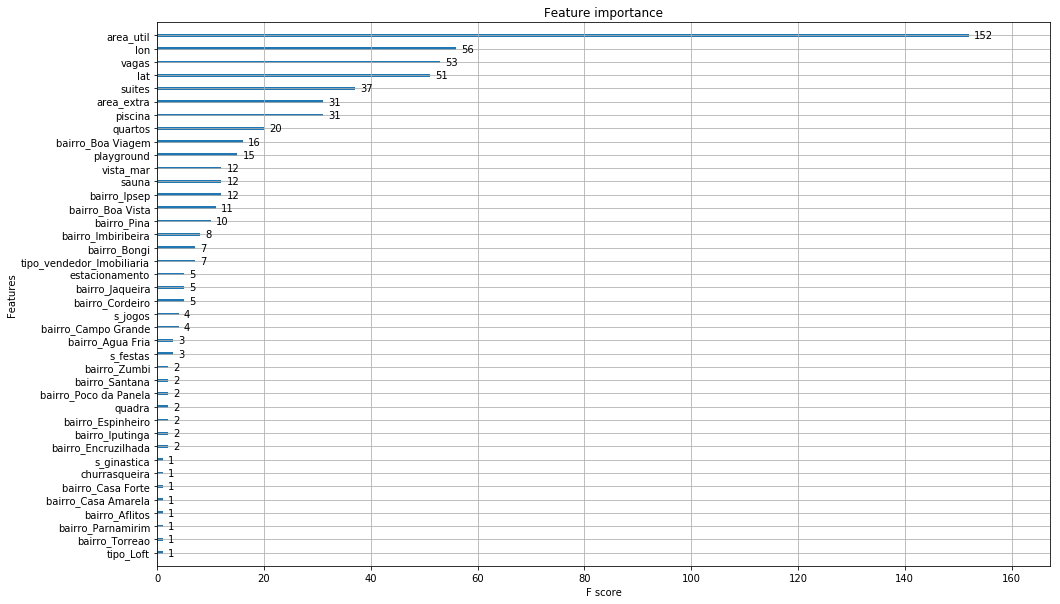

In [ ]:
from xgboost import plot_importance

model = XGBRegressor(nthread = -1)
model.fit(X_train, y_train_transformed)

f, ax = plt.subplots(figsize=(16, 10))
plot_importance(model, ax = ax)
plt.show()

Analisa-se agora um limiar ideal de corte para as features, baseando-se no gráfico acima.

In [ ]:
# Getting chart data
fscore_dict = model.get_booster().get_fscore()

# Getting threshold values
threshold_values = []
for feature in fscore_dict:
    if fscore_dict[feature] not in threshold_values:
        threshold_values.append(fscore_dict[feature])

# Building lists for later plotting
scores_y = []
        
# Setting a range for the threshold
for threshold in threshold_values:
    feature_list = [feature for feature in X_train.columns if (feature in fscore_dict) and (fscore_dict[feature] >=  threshold)]
    scores_y.append(rmse_cv(model, X_train[feature_list], y_train_transformed).mean())
    
# Plotting
#plt.figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#plt.scatter(threshold_values, scores_y)
#plt.show()

# Getting best threshold
min_value = 1
best_threshold = 1000
for i in range(len(threshold_values)):
    if scores_y [i] < min_value:
        best_threshold = threshold_values[i]

print ("Your best threshold is {}".format(best_threshold))
xgb_features_list = [feature for feature in fscore_dict if fscore_dict[feature] >= best_threshold]
print ("With this threshold, the features you want are: {}".format(xgb_features_list))

Your best threshold is 3
With this threshold, the features you want are: ['area_util', 'suites', 'vagas', 'quartos', 'lon', 'bairro_Boa Viagem', 'piscina', 'lat', 'bairro_Ipsep', 'bairro_Boa Vista', 'playground', 'sauna', 'area_extra', 'vista_mar', 'bairro_Imbiribeira', 'bairro_Pina', 'bairro_Cordeiro', 'tipo_vendedor_Imobiliaria', 'bairro_Campo Grande', 's_festas', 'bairro_Jaqueira', 'bairro_Bongi', 'estacionamento', 's_jogos', 'bairro_Agua Fria']


A seguir a análise com o *RFECV (Recursive Feature Extraction w/ Cross-Validation selection)*. O código foi comentado de forma a não tomar tempo de processamento do leitor. Para executá-lo e reproduzir os resultados, apenas retire os comentários.

In [ ]:
from sklearn.feature_selection import RFECV

#model = GradientBoostingRegressor(learning_rate = 0.082, loss = 'ls', n_estimators = 620)
#selector = RFECV (model)
#selector.fit(X_train, y_train_transformed)

#RFECV_mask = selector.support_
#print (RFECV_mask)

# Output:
#[ True  True False  True False  True False  True  True  True  True False
#  True  True False False  True  True  True False  True False  True  True
# False  True False False False False  True  True  True  True False False
# False False False False False False False  True False False False False
# False False False False False False False False False  True  True False
# False False False False  True False False  True False  True False False
#  True False False False  True False False False False False False False
#  True False  True  True  True  True False  True False]

RFECV_mask = np.array([ True,  True, False,  True, False,  True, False,  True,  True,  True,  True, False,
  True,  True, False, False,  True,  True,  True, False,  True, False,  True,  True,
 False,  True, False, False, False, False,  True,  True,  True,  True, False, False,
 False, False, False, False, False, False, False,  True, False, False, False, False,
 False, False, False, False, False, False, False, False, False,  True,  True, False,
 False, False, False, False,  True, False, False,  True, False,  True, False, False,
  True, False, False, False,  True, False, False, False, False, False, False, False,
  True, False,  True,  True,  True,  True, False,  True, False])

rfecv_features_list = []
for i in range(len(RFECV_mask)):
    if RFECV_mask[i] == True:
        rfecv_features_list.append(X_train.columns[i])
    
print ("For this metod, the features you want are: {}".format(rfecv_features_list))

For this metod, the features you want are: ['area_extra', 'area_util', 'churrasqueira', 'estacionamento', 'lat', 'lon', 'piscina', 'playground', 'quartos', 's_festas', 'sauna', 'suites', 'vagas', 'vista_mar', 'bairro_Afogados', 'bairro_Agua Fria', 'bairro_Areias', 'bairro_Benfica', 'bairro_Boa Viagem', 'bairro_Boa Vista', 'bairro_Bongi', 'bairro_Cordeiro', 'bairro_Imbiribeira', 'bairro_Ipsep', 'bairro_Madalena', 'bairro_Parnamirim', 'bairro_Pina', 'bairro_Prado', 'bairro_Sancho', 'bairro_Torre', 'bairro_Varzea', 'bairro_Zumbi', 'tipo_Apartamento', 'tipo_Casa', 'tipo_Quitinete']


Nesse momento novamente os dados de treino e teste serão manipulados de forma a recortá-los de acordo com as features selecionadas anteriormente, comparando as escolhas.

In [ ]:
# Raw X data
train_Ids = set(train['Id'].tolist())
test_Ids = set(test['Id'].tolist())
valid_Ids = set(validation['Id'].tolist())

X_train = full[full['Id'].isin(train_Ids)]
X_train.drop('Id', axis = 1, inplace = True)

X_test = full[full['Id'].isin(test_Ids)]
X_test.drop('Id', axis = 1, inplace = True)

X_valid = full[full['Id'].isin(valid_Ids)]
X_valid.drop(['Id'], axis = 1, inplace = True)

# Cropped X_data
X_train_cropped_xgb = X_train[xgb_features_list]
X_test_cropped_xgb = X_test[xgb_features_list]
X_train_cropped_rfecv = X_train[rfecv_features_list]
X_test_cropped_rfecv = X_test[rfecv_features_list]
X_valid_cropped_rfecv = X_valid[rfecv_features_list]

# Scaling data
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit(X_train).transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)
X_train_cropped_xgb_scaled = robust_scaler.fit(X_train_cropped_xgb).transform(X_train_cropped_xgb)
X_test_cropped_xgb_scaled = robust_scaler.transform(X_test_cropped_xgb)
X_train_cropped_rfecv_scaled = robust_scaler.fit(X_train_cropped_rfecv).transform(X_train_cropped_rfecv)
X_test_cropped_rfecv_scaled = robust_scaler.transform(X_test_cropped_rfecv)
X_valid_cropped_rfecv_scaled = robust_scaler.transform(X_valid_cropped_rfecv)

# Transforming data with PCA
#pca = PCA(0.95)
#X_train_scaled_transformed = pca.fit(X_train_scaled).transform(X_train_scaled)
#X_test_scaled_transformed = pca.transform(X_test_scaled)
#X_train_cropped_xgb_scaled_transformed = pca.fit(X_train_cropped_xgb_scaled).transform(X_train_cropped_xgb_scaled)
#X_test_cropped_xgb_scaled_transformed = pca.transform(X_test_cropped_xgb_scaled)
#X_train_cropped_rfecv_scaled_transformed = pca.fit(X_train_cropped_rfecv_scaled).transform(X_train_cropped_rfecv_scaled)
#X_test_cropped_rfecv_scaled_transformed = pca.transform(X_test_cropped_rfecv_scaled)
y_train_transformed = boxcox1p(train.preco, bclambda)
y_valid_transformed = boxcox1p(validation.preco, bclambda)

Serão utilizados os seguintes modelos de regressão:
* Regressão linear;
* Regressão de Lasso;
* Regressão de Florestas Aleatórias;
* Regressor de *boost* de gradiente;
* Regressor de vetores de suporte;
* Regressor *XGBoost*.

Agora será feito o teste inicial, ou seja, sem *tuning* de hiperparâmetros, dos modelos supracitados para os seguintes conjuntos de dados:
* *X_train*: conjunto de input sem tratamento;
* *X_train_cropped_xgb*: conjunto de input com features selecionadas pelo *XGBoost Regressor*;
* *X_train_cropped_rfecv*: conjunto de input com features selecionadas pelo *RFECV*;
* *X_train_scaled*: conjunto de input sem recorte após processo de escala;
* *X_train_cropped_xgb_scaled*: conjunto *X_train_cropped_xgb* após processo de escala;
* *X_train_cropped_rfecv_scaled*: conjunto *X_train_cropped_rfecv* após processo de escala;

In [ ]:
# Defining list of models we'll try (without hyper-parameters tuning)
models = [
    LinearRegression(),
    Lasso(alpha=0.01,max_iter=10000),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    XGBRegressor()
]
# Labels of the models
names = [
    'Linear Regression',
    'Lasso Regression',
    'Random Forest Regression',
    'Gradient Boosting Regression',
    'Support Vector Regression',
    'XGBoost Regression'
]

# Manipulating input
X_list = [
    X_train,
    X_train_cropped_xgb,
    X_train_cropped_rfecv,
    X_train_scaled,
    X_train_cropped_xgb_scaled,
    X_train_cropped_rfecv_scaled
]

# Getting RMSE for all models (no hyper-parameters tuning)
for X in X_list:
    print ("=" * 15)
    lower_rmse = 1000
    higher_rmse = 0
    lower_rmse_name = ""
    higher_rmse_name = ""
    for model,name in zip(models,names):
        score = rmse_cv (model, X, y_train_transformed)
        if (score.mean() < lower_rmse):
            lower_rmse = score.mean()
            lower_rmse_name = name
        if (score.mean() > higher_rmse):
            higher_rmse = score.mean()
            higher_rmse_name = name
        print("{}: {}, {}".format(name,score.mean(),score.std()))
    print ("--- Best result: {} with {}".format(lower_rmse_name, lower_rmse))
    print ("--- Worst result: {} with {}".format(higher_rmse_name, higher_rmse))

Linear Regression: 6928877053.784747, 11598442661.712511
Lasso Regression: 0.32749120214283933, 0.01189097064384957
Random Forest Regression: 0.24564813739487681, 0.011487463895544291
Gradient Boosting Regression: 0.2349151154594688, 0.012452241322908668
Support Vector Regression: 0.288903062536788, 0.009370346207593814
XGBoost Regression: 0.23720724745743413, 0.012656820301328956
--- Best result: Gradient Boosting Regression with 0.2349151154594688
--- Worst result: Linear Regression with 6928877053.784747
Linear Regression: 0.2850388455197687, 0.008162870244534853
Lasso Regression: 0.32749213652751036, 0.011891450828885946
Random Forest Regression: 0.2455668068590676, 0.012398459834071786
Gradient Boosting Regression: 0.23474744033498066, 0.012323766092419135
Support Vector Regression: 0.28567568036306934, 0.010806889985666618
XGBoost Regression: 0.2374039833279567, 0.012096276258467929
--- Best result: Gradient Boosting Regression with 0.23474744033498066
--- Worst result: Lasso Reg

É possível observar que conjuntos de dados diferentes geram resultados diferentes com modelos diferentes. De modo a aprimorar os resultados, será feita agora o *tuning* dos hiperparâmetros, com *GridSearch*, baseando-se no *dataset* que se saiu melhor para cada modelo.

In [ ]:
# Grid search for hyper-parameters
class grid():
    def __init__ (self, model):
        self.model = model
    def grid_get (self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

Uma flag denominada *make_search* será definida como *False* para pular a parte de *GridSearch*, devido ao seu altíssimo custo computacional. Os resultados são demonstrados posteriormente.

In [ ]:
make_search = False

In [ ]:
# Grid search for Lasso
if (make_search):
    dataset = X_train_scaled_transformed
    grid(Lasso()).grid_get(dataset, y_train_transformed,
                           {'alpha':np.linspace(0, .01, 21),
                            'max_iter':[max_iter]})
    
# Found alpha = 0.0005

In [ ]:
# Grid search for Random Forest Regressor
if (make_search):
    dataset = X_train
    grid(RandomForestRegressor()).grid_get(dataset, y_train_transformed,
                                          {'n_estimators' : np.linspace(100, 500, 6).astype(int),
                                          'oob_score' : [True, False],
                                          'n_jobs' : [-1]})
    
# Found n_estimators = 260, oob_score = False

In [ ]:
# Grid search for SVR
if (make_search):
    dataset = X_train_scaled_transformed
    grid(SVR()).grid_get(dataset, y_train_transformed, {
        'kernel' : ['rbf', 'poly'],
        'degree' : range(1, 5),
        'max_iter' : [15000]
    })
    
# Found kernel = 'rbf'

In [ ]:
# Grid search for Gradient Boost Regressor
if (make_search):
    dataset = X_train
    grid(GradientBoostingRegressor()).grid_get(dataset, y_train_transformed, {
        'loss' : ['ls', 'huber'],
        'learning_rate' : np.linspace(0.01, 0.1, 11),
        'n_estimators' : np.linspace(300, 700, 6).astype(int)
    })
    
# Found learning_rate = 0.082, loss = 'ls', n_estimators = 620

Após o *tuning* de hiper-parâmetros, os resultados serão revistos.

In [ ]:
# Defining list of models with hyper-parameters tuned
models = [
    LinearRegression(),
    Lasso(alpha = 0.0005, max_iter = max_iter),
    RandomForestRegressor(n_estimators = 260, n_jobs = -1, oob_score = False),
    SVR(kernel = 'rbf', max_iter = max_iter),
    GradientBoostingRegressor(learning_rate = 0.082, loss = 'ls', n_estimators = 620),
    XGBRegressor(nthread = -1)
]
# Labels of the models
names = [
    'Linear Regression',
    'Lasso Regression',
    'Random Forest Regression',
    'Support Vector Regression',
    'Gradient Boosting Regression',
    'XGBoost Regression'
]

# Manipulating input
X_list = [
    X_train,
    X_train_cropped_xgb,
    X_train_cropped_rfecv,
    X_train_scaled,
    X_train_cropped_xgb_scaled,
    X_train_cropped_rfecv_scaled
]

# Getting RMSE for all models (after hyper-parameters tuning)
for X in X_list:
    print ("=" * 15)
    lower_rmse = 1000
    higher_rmse = 0
    lower_rmse_name = ""
    higher_rmse_name = ""
    for model,name in zip(models,names):
        score = rmse_cv (model, X, y_train_transformed)
        if (score.mean() < lower_rmse):
            lower_rmse = score.mean()
            lower_rmse_name = name
        if (score.mean() > higher_rmse):
            higher_rmse = score.mean()
            higher_rmse_name = name
        print("{}: {}, {}".format(name,score.mean(),score.std()))
    print ("--- Best result: {} with {}".format(lower_rmse_name, lower_rmse))
    print ("--- Worst result: {} with {}".format(higher_rmse_name, higher_rmse))

Linear Regression: 6928877053.784747, 11598442661.712511
Lasso Regression: 0.27584255119855194, 0.009217845674275046
Random Forest Regression: 0.23405068936469148, 0.013633481666728365
Support Vector Regression: 0.288903062536788, 0.009370346207593814
Gradient Boosting Regression: 0.23186964947960104, 0.014188573877981484
XGBoost Regression: 0.23720724745743413, 0.012656820301328956
--- Best result: Gradient Boosting Regression with 0.23186964947960104
--- Worst result: Linear Regression with 6928877053.784747
Linear Regression: 0.2850388455197687, 0.008162870244534853
Lasso Regression: 0.289130616528295, 0.011141344259421463
Random Forest Regression: 0.2358711603156273, 0.01293191915959567
Support Vector Regression: 0.28567568036306934, 0.010806889985666618
Gradient Boosting Regression: 0.2307210076365454, 0.012386251878546039
XGBoost Regression: 0.2374039833279567, 0.012096276258467929
--- Best result: Gradient Boosting Regression with 0.2307210076365454
--- Worst result: Lasso Regre

Com os resultados acima, podemos ver que após o processo de escala os resultados são, no geral, melhores. Desconsiderando *datasets* pré-escala, os melhores modelos, seus respectivos *datasets* e os erros médios quadráticos associados foram os seguintes:

* 1º: *Gradient Boosting Regression* com *X_train_cropped_rfecv_scaled*: 0.2241625;
* 2º: *Gradient Boosting Regression* com *X_train_cropped_xgb_scaled*: 0.2249785;
* 3º: *Gradient Boosting Regression* com *X_train_scaled*: 0.2252590;
* 4º: *Random Forest Regression* com *X_train_scaled*: 0.2265576;
* 5º: *Random Forest Regression* com *X_train_cropped_rfecv_scaled*: 0.2268213;
* 6º: *Random Forest Regression* com *X_train_cropped_xgb_scaled*: 0.2299492;
* 7º: *XGBoost Regression* com *X_train_cropped_rfecv_scaled*: 0.2335460;
* 8º: *XGBoost Regression* com *X_train_scaled*: 0.2336808;
* 9º: *XGBoost Regression* com *X_train_cropped_xgb_scaled*: 0.2337243;
* 10º: *Support Vector Regression* com *X_train_cropped_rfecv_scaled*: 0.2339725.

A partir desses resultados, serão consideradas possíveis combinações entre os seguintes modelos, supracitados, a fim de tentar adquirir melhores resultados:
* *Gradient Boosting Regression*;
* *Random Forest Regression*;
* *XGBoost Regression*;
* *Support Vector Regression*;


In [ ]:
# Declaring models
rfregressor = RandomForestRegressor(n_estimators = 260, n_jobs = -1, oob_score = False)
#rfregressor.fit(X_train_scaled, y_train_transformed)

svregressor = SVR(kernel = 'rbf', max_iter = max_iter)
#svregressor.fit(X_train_cropped_rfecv_scaled, y_train_transformed)

gbregressor = GradientBoostingRegressor(learning_rate = 0.082, loss = 'ls', n_estimators = 620)
#gbregressor.fit(X_train_cropped_rfecv_scaled, y_train_transformed)

xgbregressor = XGBRegressor(nthread = -1)
#xgbregressor.fit(X_train_cropped_rfecv_scaled, y_train_transformed)

# Making a list
models_list = [
    rfregressor,
    svregressor,
    gbregressor,
    xgbregressor
]

models_labels = [
    'Random Forest',
    'Support Vector',
    'Gradient Boosting',
    'XGBoost'
]

Após a declaração dos modelos, o que será utilizado como método para combinação é o *stacking*, que utiliza informação de múltiplos modelos de predição para gerar um novo modelo. Serão feitas quatro combinações, alterando-se apenas o meta-modelo.

In [ ]:
# Making a class for easier using of stacking
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i, model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X, y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index, i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train, y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis = 1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self, X, y, test_X):
        oof = np.zeros((X.shape[0], len(self.mod)))
        test_single = np.zeros((test_X.shape[0], 5))
        test_mean = np.zeros((test_X.shape[0], len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index, val_index) in enumerate(self.kf.split(X, y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index], y[train_index])
                oof[val_index, i] = clone_model.predict(X[val_index])
                test_single[:, j] = clone_model.predict(test_X)
            test_mean[:, i] = test_single.mean(axis = 1)
        return oof, test_mean

In [ ]:
# Imputing data
X_imputed = Imputer().fit_transform(X_train_cropped_rfecv_scaled)
imputer = Imputer().fit(y_train_transformed.values.reshape(-1,1))
y_imputed = imputer.transform(y_train_transformed.values.reshape(-1,1)).ravel()
y_valid_imputed = imputer.transform(y_valid_transformed.values.reshape(-1,1)).ravel()

# First combination
stack_model_1 = stacking(mod=[gbregressor, svregressor, xgbregressor], meta_model = rfregressor)
score = rmse_cv(stack_model_1, X_imputed, y_imputed)
print ("Score w/ RFRegressor as meta-model: {}".format(score.mean()))

# Second combination
stack_model_2 = stacking(mod=[rfregressor, gbregressor, xgbregressor], meta_model = svregressor)
score = rmse_cv(stack_model_2, X_imputed, y_imputed)
print ("Score w/ SVRegressor as meta-model: {}".format(score.mean()))

# Third combination
stack_model_3 = stacking(mod=[rfregressor, svregressor, gbregressor], meta_model = xgbregressor)
score = rmse_cv(stack_model_3, X_imputed, y_imputed)
print ("Score w/ XGBRegressor as meta-model: {}".format(score.mean()))

# Fourth combination
stack_model_4 = stacking(mod=[rfregressor, svregressor, xgbregressor], meta_model = gbregressor)
score = rmse_cv(stack_model_4, X_imputed, y_imputed)
print ("Score w/ GBRegressor as meta-model: {}".format(score.mean()))

Score w/ RFRegressor as meta-model: 0.24039667219245597
Score w/ SVRegressor as meta-model: 0.2247042283326731
Score w/ XGBRegressor as meta-model: 0.22824441832709258
Score w/ GBRegressor as meta-model: 0.2400455635481919


Como visto acima, obtivemos os melhores resultados com o *Support Vector Regressor* e *XGBoost Regressor* como meta-modelos. Como a *stack* cujo meta-modelo é o *Support Vector Regressor* obteve melhor resultado, essa será utilizada para predizer os dados de teste.

In [ ]:
# Extracting features from model
X_train_stack, X_test_stack = stack_model_2.get_oof(X_imputed, y_imputed, X_test_cropped_rfecv_scaled)
X_train_stack, X_valid_stack = stack_model_2.get_oof(X_imputed, y_imputed, X_valid_cropped_rfecv_scaled)

# Checking shapes
X_train_stack.shape, X_test_stack.shape, X_imputed.shape, y_imputed.shape, X_valid_stack.shape

((3489, 3), (2000, 3), (3489, 35), (3489,), (1170, 3))

In [ ]:
# Stacking data
X_train_add = np.hstack((X_imputed, X_train_stack))
X_test_add = np.hstack((X_test_cropped_rfecv_scaled, X_test_stack))
X_valid_add = np.hstack((X_valid_cropped_rfecv_scaled, X_valid_stack))

# Checking shapes
print(X_train_add.shape, X_test_add.shape, X_valid_add.shape)

# Training model
stack_model_2 = stacking(mod=[rfregressor, gbregressor, xgbregressor], meta_model = svregressor)
stack_model_2.fit(X_train_add, y_imputed)

(3489, 38) (2000, 38) (1170, 38)


stacking(meta_model=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=15000, shrinking=True, tol=0.001, verbose=False),
     mod=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=26...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)])

In [ ]:
# Checking score
score = rmse_cv(stack_model_2, X_train_add, y_imputed)
print(score.mean())

score = rmse_cv(stack_model_2, X_valid_add, y_valid_imputed)
print(score.mean())

0.22507496619534204
0.3019064923049736


In [ ]:
# Making predictions
full_X_train = np.concatenate((X_train_add, X_valid_add))
full_y_train = np.concatenate((y_imputed, y_valid_imputed))

print (full_X_train.shape, full_y_train.shape)

model = stack_model_2.fit(full_X_train, full_y_train)
prediction = model.predict(X_test_add)

(4659, 38) (4659,)


Agora, como a predição está transformada, precisa-se realizar a inversa dessa transformação, a fim de retornar os valores dos preços dos imóveis, para submissão no Kaggle.

In [ ]:
from scipy.special import inv_boxcox1p
submission_data = inv_boxcox1p(prediction, bclambda)
print (submission_data)

O exemplo de submissão baixado do site exige um padrão de formatação para a submissão, o qual será gerado agora.

In [ ]:
dataframe = pd.DataFrame({
    'Id' : test.index,
    "preco" : submission_data
})

Agora o *dataframe* será exportado para um arquivo *.csv* para submissão.

In [ ]:
dataframe.to_csv('results.csv', index = False)